# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [80]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# # using SQLite Table to read data.
# con = sqlite3.connect('database.sqlite') 

# # filtering only positive and negative reviews i.e. 
# # not taking into consideration those reviews with Score=3
# # SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# # you can change the number to any other number based on your computing power

# # filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# # for tsne assignment you can take 5k data points

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# # Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
# def partition(x):
#     if x < 3:
#         return 0
#     return 1

# #changing reviews with score less than 3 to be positive and vice-versa
# actualScore = filtered_data['Score']
# positiveNegative = actualScore.map(partition) 
# filtered_data['Score'] = positiveNegative
# print("Number of data points in our data", filtered_data.shape)
# filtered_data.head(3)

In [3]:
# display = pd.read_sql_query("""
# SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
# FROM Reviews
# GROUP BY UserId
# HAVING COUNT(*)>1
# """, con)

In [4]:
# print(display.shape)
# display.head()

In [5]:
# display[display['UserId']=='AZY10LLTJ71NX']

In [6]:
# display['COUNT(*)'].sum()

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
# display= pd.read_sql_query("""
# SELECT *
# FROM Reviews
# WHERE Score != 3 AND UserId="AR5J8UI46CURR"
# ORDER BY ProductID
# """, con)
# display.head()

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
# #Sorting data according to ProductId in ascending order
# sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
# #Deduplication of entries
# final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
# final.shape

In [10]:
# #Checking to see how much % of data still remains
# (final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
# display= pd.read_sql_query("""
# SELECT *
# FROM Reviews
# WHERE Score != 3 AND Id=44737 OR Id=64422
# ORDER BY ProductID
# """, con)

# display.head()

In [12]:
# final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
# #Before starting the next phase of preprocessing lets see the number of entries left
# print(final.shape)

# #How many positive and negative reviews are present in our dataset?
# final['Score'].value_counts()

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# # printing some random reviews
# sent_0 = final['Text'].values[0]
# print(sent_0)
# print("="*50)

# sent_1000 = final['Text'].values[1000]
# print(sent_1000)
# print("="*50)

# sent_1500 = final['Text'].values[1500]
# print(sent_1500)
# print("="*50)

# sent_4900 = final['Text'].values[4900]
# print(sent_4900)
# print("="*50)

In [15]:
# # remove urls from text python: https://stackoverflow.com/a/40823105/4084039
# sent_0 = re.sub(r"http\S+", "", sent_0)
# sent_1000 = re.sub(r"http\S+", "", sent_1000)
# sent_150 = re.sub(r"http\S+", "", sent_1500)
# sent_4900 = re.sub(r"http\S+", "", sent_4900)

# print(sent_0)

In [16]:
# # https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
# from bs4 import BeautifulSoup

# soup = BeautifulSoup(sent_0, 'lxml')
# text = soup.get_text()
# print(text)
# print("="*50)

# soup = BeautifulSoup(sent_1000, 'lxml')
# text = soup.get_text()
# print(text)
# print("="*50)

# soup = BeautifulSoup(sent_1500, 'lxml')
# text = soup.get_text()
# print(text)
# print("="*50)

# soup = BeautifulSoup(sent_4900, 'lxml')
# text = soup.get_text()
# print(text)

In [17]:
# # https://stackoverflow.com/a/47091490/4084039
# import re

# def decontracted(phrase):
#     # specific
#     phrase = re.sub(r"won't", "will not", phrase)
#     phrase = re.sub(r"can\'t", "can not", phrase)

#     # general
#     phrase = re.sub(r"n\'t", " not", phrase)
#     phrase = re.sub(r"\'re", " are", phrase)
#     phrase = re.sub(r"\'s", " is", phrase)
#     phrase = re.sub(r"\'d", " would", phrase)
#     phrase = re.sub(r"\'ll", " will", phrase)
#     phrase = re.sub(r"\'t", " not", phrase)
#     phrase = re.sub(r"\'ve", " have", phrase)
#     phrase = re.sub(r"\'m", " am", phrase)
#     return phrase

In [18]:
# sent_1500 = decontracted(sent_1500)
# print(sent_1500)
# print("="*50)

In [19]:
# #remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
# sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
# print(sent_0)

In [20]:
# #remove spacial character: https://stackoverflow.com/a/5843547/4084039
# sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
# print(sent_1500)

In [21]:
# # https://gist.github.com/sebleier/554280
# # we are removing the words from the stop words list: 'no', 'nor', 'not'
# # <br /><br /> ==> after the above steps, we are getting "br br"
# # we are including them into stop words list
# # instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

# stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
#             "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
#             'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
#             'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
#             'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
#             'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
#             'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
#             'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
#             'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
#             'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
#             's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
#             've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
#             "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
#             "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
#             'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# # Combining all the above stundents 
# from tqdm import tqdm
# preprocessed_reviews = []
# # tqdm is for printing the status bar
# for sentance in tqdm(final['Text'].values):
#     sentance = re.sub(r"http\S+", "", sentance)
#     sentance = BeautifulSoup(sentance, 'lxml').get_text()
#     sentance = decontracted(sentance)
#     sentance = re.sub("\S*\d\S*", "", sentance).strip()
#     sentance = re.sub('[^A-Za-z]+', ' ', sentance)
#     # https://gist.github.com/sebleier/554280
#     sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
#     preprocessed_reviews.append(sentance.strip())

In [23]:
# preprocessed_reviews[1500]

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [6]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [24]:
# #BoW
# count_vect = CountVectorizer() #in scikit-learn
# count_vect.fit(preprocessed_reviews)
# print("some feature names ", count_vect.get_feature_names()[:10])
# print('='*50)

# final_counts = count_vect.transform(preprocessed_reviews)
# print("the type of count vectorizer ",type(final_counts))
# print("the shape of out text BOW vectorizer ",final_counts.get_shape())
# print("the number of unique words ", final_counts.get_shape()[1])

## [4.2] Bi-Grams and n-Grams.

In [25]:
# #bi-gram, tri-gram and n-gram

# #removing stop words like "not" should be avoided before building n-grams
# # count_vect = CountVectorizer(ngram_range=(1,2))
# # please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# # you can choose these numebrs min_df=10, max_features=5000, of your choice
# count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
# final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
# print("the type of count vectorizer ",type(final_bigram_counts))
# print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
# print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

## [4.3] TF-IDF

In [26]:
# tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
# tf_idf_vect.fit(preprocessed_reviews)
# print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
# print('='*50)

# final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
# print("the type of count vectorizer ",type(final_tf_idf))
# print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
# print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

## [4.4] Word2Vec

In [27]:
# # Train your own Word2Vec model using your own text corpus
# i=0
# list_of_sentance=[]
# for sentance in preprocessed_reviews:
#     list_of_sentance.append(sentance.split())

In [28]:
# # Using Google News Word2Vectors

# # in this project we are using a pretrained model by google
# # its 3.3G file, once you load this into your memory 
# # it occupies ~9Gb, so please do this step only if you have >12G of ram
# # we will provide a pickle file wich contains a dict , 
# # and it contains all our courpus words as keys and  model[word] as values
# # To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# # from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# # it's 1.9GB in size.


# # http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# # you can comment this whole cell
# # or change these varible according to your need

# is_your_ram_gt_16g=False
# want_to_use_google_w2v = False
# want_to_train_w2v = True

# if want_to_train_w2v:
#     # min_count = 5 considers only words that occured atleast 5 times
#     w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
#     print(w2v_model.wv.most_similar('great'))
#     print('='*50)
#     print(w2v_model.wv.most_similar('worst'))
    
# elif want_to_use_google_w2v and is_your_ram_gt_16g:
#     if os.path.isfile('GoogleNews-vectors-negative300.bin'):
#         w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
#         print(w2v_model.wv.most_similar('great'))
#         print(w2v_model.wv.most_similar('worst'))
#     else:
#         print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

In [29]:
# w2v_words = list(w2v_model.wv.vocab)
# print("number of words that occured minimum 5 times ",len(w2v_words))
# print("sample words ", w2v_words[0:50])

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [30]:
# # average Word2Vec
# # compute average word2vec for each review.
# sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
# for sent in tqdm(list_of_sentance): # for each review/sentence
#     sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
#     cnt_words =0; # num of words with a valid vector in the sentence/review
#     for word in sent: # for each word in a review/sentence
#         if word in w2v_words:
#             vec = w2v_model.wv[word]
#             sent_vec += vec
#             cnt_words += 1
#     if cnt_words != 0:
#         sent_vec /= cnt_words
#     sent_vectors.append(sent_vec)
# print(len(sent_vectors))
# print(len(sent_vectors[0]))

#### [4.4.1.2] TFIDF weighted W2v

In [31]:
# # S = ["abc def pqr", "def def def abc", "pqr pqr def"]
# model = TfidfVectorizer()
# tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# # we are converting a dictionary with word as a key, and the idf as a value
# dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [33]:
# # TF-IDF weighted Word2Vec
# tfidf_feat = model.get_feature_names() # tfidf words/col-names
# # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

# tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
# row=0;
# for sent in tqdm(list_of_sentance): # for each review/sentence 
#     sent_vec = np.zeros(50) # as word vectors are of zero length
#     weight_sum =0; # num of words with a valid vector in the sentence/review
#     for word in sent: # for each word in a review/sentence
#         if word in w2v_words and word in tfidf_feat:
#             vec = w2v_model.wv[word]
# #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
#             # to reduce the computation we are 
#             # dictionary[word] = idf value of word in whole courpus
#             # sent.count(word) = tf valeus of word in this review
#             tf_idf = dictionary[word]*(sent.count(word)/len(sent))
#             sent_vec += (vec * tf_idf)
#             weight_sum += tf_idf
#     if weight_sum != 0:
#         sent_vec /= weight_sum
#     tfidf_sent_vectors.append(sent_vec)
#     row += 1

# Data Loading

In [2]:
clean_text_data=pd.read_csv("./input/Clean_data.csv")

In [3]:
clean_text_data.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...


In [4]:
avg_w2v_df=pd.read_csv("./input/avg_w2v_df.csv")
tfidf_w2v_df=pd.read_csv("./input/tfidf_w2v_df.csv")
print(" avg_w2v_df ",avg_w2v_df.shape,"tfidf_w2v_df ",tfidf_w2v_df.shape,"clean_text_data",clean_text_data.shape)

 avg_w2v_df  (364171, 52) tfidf_w2v_df  (364171, 52) clean_text_data (364171, 11)


In [37]:
avg_w2v_df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,Score,Time
0,-0.758505,-0.172168,-0.385203,-0.241811,-0.394415,-0.073644,-0.22428,0.286488,-0.087994,-0.419489,...,-0.957424,0.008468,-0.998245,-0.097955,0.065205,-0.238957,-0.527055,0.183418,1.0,1.303862e+09


In [38]:
tfidf_w2v_df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,Score,Time
0,-0.631241,-0.058037,-0.317851,-0.147253,-0.524769,0.303866,-0.254059,0.337368,0.037931,-0.362123,...,-0.997835,0.090512,-0.722301,-0.040754,-0.208076,-0.658077,-0.648217,0.04987,1.0,1.303862e+09


In [39]:
# Checking the positive and negative labels
clean_text_data['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [5]:
#Spliting records into train, cv and test using based on time

def split_train_cv_test(df,sample_size):
    filter_data_positive=df[df.Score==1].sample(sample_size,random_state=17)
    filter_data_positive.sort_values(by='Time',inplace=True,ascending=True)
    filter_data_negative=df[df.Score==0].sample(sample_size,random_state=17)
    filter_data_negative.sort_values(by='Time',inplace=True,ascending=True)
    # Splitting Train,CV and Test for positive data
    row=filter_data_positive.shape[0]
    split=int(row*0.6)
    train_data_positive=filter_data_positive[:split]
    cv_data_positive=filter_data_positive[split:int(row*0.8)]
    test_data_positive=filter_data_positive[int(row*0.8):row]
    print("Total_positive_data",filter_data_positive.shape)
    print("train",train_data_positive.shape,"CV",cv_data_positive.shape,"test",test_data_positive.shape)
    # Splitting Train,CV and Test for -ve data
    row=filter_data_negative.shape[0]
    split=int(row*0.6)
    train_data_negative=filter_data_negative[:split]
    cv_data_negative=filter_data_negative[split:int(row*0.8)]
    test_data_negative=filter_data_negative[int(row*0.8):row]
    print("Total_negative_data",filter_data_negative.shape)
    print("train",train_data_negative.shape,"CV",cv_data_negative.shape,"test",test_data_negative.shape)
    # Combining +ve and -ve train data and sorting based on time
    train_data=np.vstack((train_data_positive, train_data_negative))
    train_data=pd.DataFrame(train_data)
    train_data.columns=df.columns
    train_data.sort_values(by='Time',inplace=True,ascending=True)
    print("train_data",train_data.shape)
    # Checking the positive and negative labels
    train_data['Score'].value_counts()
    # Combining +ve and -ve CV data and sorting based on time
    cv_data=np.vstack((cv_data_positive,cv_data_negative))
    cv_data=pd.DataFrame(cv_data)
    cv_data.columns=df.columns
    cv_data.sort_values(by='Time',inplace=True,ascending=True)
    print("cv_data",cv_data.shape)
    # Checking the positive and negative labels
    cv_data['Score'].value_counts()
    # Combining +ve and -ve test data and sorting based on time
    test_data=np.vstack((test_data_positive, test_data_negative))
    test_data=pd.DataFrame(test_data)
    test_data.columns=df.columns
    test_data.sort_values(by='Time',inplace=True,ascending=True)
    print("test_data",test_data.shape)
    # Checking the positive and negative labels
    test_data['Score'].value_counts()
    return train_data,cv_data,test_data

In [6]:
# splitting text data for BOW and TFIDF
train_text_data,cv_text_data,test_text_data=split_train_cv_test(clean_text_data,50000)

Total_positive_data (50000, 11)
train (30000, 11) CV (10000, 11) test (10000, 11)
Total_negative_data (50000, 11)
train (30000, 11) CV (10000, 11) test (10000, 11)
train_data (60000, 11)
cv_data (20000, 11)
test_data (20000, 11)


In [7]:
# splitting avg Word2Vec data
train_avg_w2v_data,cv_avg_w2v_data,test_avg_w2v_data=split_train_cv_test(avg_w2v_df,30000)

Total_positive_data (30000, 52)
train (18000, 52) CV (6000, 52) test (6000, 52)
Total_negative_data (30000, 52)
train (18000, 52) CV (6000, 52) test (6000, 52)
train_data (36000, 52)
cv_data (12000, 52)
test_data (12000, 52)


In [8]:
# splitting TFIDF Word2Vec data
train_tfidf_w2v_data,cv_tfidf_w2v_data,test_tfidf_w2v_data=split_train_cv_test(tfidf_w2v_df,30000)

Total_positive_data (30000, 52)
train (18000, 52) CV (6000, 52) test (6000, 52)
Total_negative_data (30000, 52)
train (18000, 52) CV (6000, 52) test (6000, 52)
train_data (36000, 52)
cv_data (12000, 52)
test_data (12000, 52)


In [44]:
train_tfidf_w2v_data.head(1)

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,Score,Time
18000,-0.184549,-0.468398,1.121426,-0.017792,0.00297,-1.454604,0.554264,0.349232,0.107937,-0.539893,...,0.57634,-0.039829,-0.028913,1.05411,0.81801,0.258794,0.055568,0.387729,0.0,948240000.0


In [45]:
train_tfidf_w2v_data.head(1)

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,Score,Time
18000,-0.184549,-0.468398,1.121426,-0.017792,0.00297,-1.454604,0.554264,0.349232,0.107937,-0.539893,...,0.57634,-0.039829,-0.028913,1.05411,0.81801,0.258794,0.055568,0.387729,0.0,948240000.0


In [46]:
train_text_data.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,1,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,one movi movi collect fill comedi action whate...


# [5] Assignment 9: Random Forests

<ol>
    <li><strong>Apply Random Forests & GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 20 important features and represent them in a word cloud. Do this for BOW & TFIDF.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='3d_plot.JPG' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>(or)</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='heat_map.JPG' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying RF

### [5.1.1] Applying Random Forests on BOW,<font color='red'> SET 1</font>

In [47]:
# Please write all the code with proper documentation
import gc; gc.collect()
# Converting text to vector using Bag of words to all train, CV and test
count_vect = CountVectorizer(min_df=10,max_features=1000 ) #in scikit-learn
training_counts = count_vect.fit_transform(train_text_data['CleanedText'])
cv_counts = count_vect.transform(cv_text_data['CleanedText'])
test_counts = count_vect.transform(test_text_data['CleanedText'])
gc.collect()

0

In [48]:
# converting sparse vector to dense vector
training_count=training_counts.toarray()
print(" training_counts ",training_counts.shape,"cv_counts ",cv_counts.shape,"test_counts",test_counts.shape)
cv_count=cv_counts.toarray()
test_count=test_counts.toarray()
# removing unused object
gc.collect()
train_traget=train_text_data['Score'].astype('int')
cv_target=cv_text_data['Score'].astype('int')
test_target=test_text_data['Score'].astype('int')

 training_counts  (60000, 1000) cv_counts  (20000, 1000) test_counts (20000, 1000)


In [50]:
# Compute train AUC also

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#Simple Cross Validation
estimators=[1, 5, 10, 50, 100, 500]
min_sample=[5, 10, 100, 500]
returned_pram1=dict()
returned_pram2=dict()
returned_pram_train1=dict()
returned_pram_train2=dict()
for i in tqdm(estimators):
    for j in tqdm(min_sample):
        # instantiate learning model
        clf = RandomForestClassifier(criterion='gini', n_estimators=i,min_samples_split=j, n_jobs=-1)
        # fitting the model on crossvalidation train
        clf.fit(training_count, train_traget)
        # predict the response on the crossvalidation train
        pred_cv = clf.predict(cv_count)
        # evaluate CV accuracy
        acc_cv = accuracy_score(cv_target, pred_cv, normalize=True) * float(100)
        auc_cv=roc_auc_score(cv_target, pred_cv)
        auc_train=roc_auc_score(train_traget, clf.predict(training_count))
        print(" No of estimators: ",i," min_sample to break: ",j," AUC: ",auc_cv," Acc: ",acc_cv," auc_train ",auc_train)
        returned_pram1.update({i:auc_cv})
        key= str(i)+" , "+str(j)
        returned_pram2.update({key:auc_cv})
        returned_pram_train1.update({i:auc_train})
        returned_pram_train2.update({key:auc_train})
    gc.collect()

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

 No of estimators:  1  min_sample to break:  5  AUC:  0.70985  Acc:  70.985  auc_train  0.8586833333333332



 25%|█████████████████████                                                               | 1/4 [00:01<00:03,  1.31s/it]

 No of estimators:  1  min_sample to break:  10  AUC:  0.7214  Acc:  72.14  auc_train  0.8477499999999999



 50%|██████████████████████████████████████████                                          | 2/4 [00:02<00:02,  1.26s/it]

 No of estimators:  1  min_sample to break:  100  AUC:  0.7094  Acc:  70.94  auc_train  0.7864166666666668



 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:03<00:01,  1.22s/it]

 No of estimators:  1  min_sample to break:  500  AUC:  0.7457999999999999  Acc:  74.58  auc_train  0.7578166666666666



  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

 No of estimators:  5  min_sample to break:  5  AUC:  0.78135  Acc:  78.135  auc_train  0.95775



 25%|█████████████████████                                                               | 1/4 [00:01<00:05,  1.77s/it]

 No of estimators:  5  min_sample to break:  10  AUC:  0.782  Acc:  78.2  auc_train  0.9477000000000001



 50%|██████████████████████████████████████████                                          | 2/4 [00:03<00:03,  1.81s/it]

 No of estimators:  5  min_sample to break:  100  AUC:  0.8000999999999999  Acc:  80.01  auc_train  0.8881



 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:05<00:01,  1.80s/it]

 No of estimators:  5  min_sample to break:  500  AUC:  0.8081999999999999  Acc:  80.82000000000001  auc_train  0.8355333333333334



  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

 No of estimators:  10  min_sample to break:  5  AUC:  0.8117000000000001  Acc:  81.17  auc_train  0.9795500000000001



 25%|█████████████████████                                                               | 1/4 [00:02<00:08,  2.81s/it]

 No of estimators:  10  min_sample to break:  10  AUC:  0.8166  Acc:  81.66  auc_train  0.9697



 50%|██████████████████████████████████████████                                          | 2/4 [00:05<00:05,  2.82s/it]

 No of estimators:  10  min_sample to break:  100  AUC:  0.8227499999999999  Acc:  82.27499999999999  auc_train  0.9134666666666666



 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:08<00:02,  2.83s/it]

 No of estimators:  10  min_sample to break:  500  AUC:  0.8212999999999999  Acc:  82.13000000000001  auc_train  0.8476333333333333



  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

 No of estimators:  50  min_sample to break:  5  AUC:  0.8437000000000001  Acc:  84.37  auc_train  0.9928833333333333



 25%|█████████████████████                                                               | 1/4 [00:11<00:34, 11.50s/it]

 No of estimators:  50  min_sample to break:  10  AUC:  0.8431500000000001  Acc:  84.315  auc_train  0.9853333333333334



 50%|██████████████████████████████████████████                                          | 2/4 [00:22<00:22, 11.46s/it]

 No of estimators:  50  min_sample to break:  100  AUC:  0.8411500000000001  Acc:  84.115  auc_train  0.9368833333333334



 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:33<00:11, 11.24s/it]

 No of estimators:  50  min_sample to break:  500  AUC:  0.8414  Acc:  84.14  auc_train  0.8676833333333334



  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

 No of estimators:  100  min_sample to break:  5  AUC:  0.84805  Acc:  84.80499999999999  auc_train  0.99395



 25%|█████████████████████                                                               | 1/4 [00:22<01:07, 22.51s/it]

 No of estimators:  100  min_sample to break:  10  AUC:  0.84705  Acc:  84.705  auc_train  0.9874000000000002



 50%|██████████████████████████████████████████                                          | 2/4 [00:44<00:44, 22.25s/it]

 No of estimators:  100  min_sample to break:  100  AUC:  0.8468000000000001  Acc:  84.68  auc_train  0.94055



 75%|███████████████████████████████████████████████████████████████                     | 3/4 [01:05<00:21, 21.98s/it]

 No of estimators:  100  min_sample to break:  500  AUC:  0.84065  Acc:  84.065  auc_train  0.8653833333333333



  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

 No of estimators:  500  min_sample to break:  5  AUC:  0.8527000000000001  Acc:  85.27  auc_train  0.99485



 25%|████████████████████▊                                                              | 1/4 [01:48<05:25, 108.46s/it]

 No of estimators:  500  min_sample to break:  10  AUC:  0.85265  Acc:  85.265  auc_train  0.98795



 50%|█████████████████████████████████████████▌                                         | 2/4 [03:38<03:37, 108.88s/it]

 No of estimators:  500  min_sample to break:  100  AUC:  0.8485  Acc:  84.85000000000001  auc_train  0.9438333333333334



 75%|██████████████████████████████████████████████████████████████▎                    | 3/4 [05:19<01:46, 106.58s/it]

 No of estimators:  500  min_sample to break:  500  AUC:  0.8399500000000002  Acc:  83.995  auc_train  0.8665666666666667



100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [09:19<00:00, 149.38s/it]


In [52]:
test_auc=[value for value in returned_pram2.values()]
train_auc=[value for value in returned_pram_train2.values()]
test_auc1=np.reshape(test_auc, (6, 4))
train_auc1=np.reshape(train_auc, (6, 4))

In [18]:
def plot_tables_metrics(data_matrix, x_tick,y_tick,x_label,ylabel, title):
    import seaborn as sns;
    ax = sns.heatmap(pd.DataFrame(data_matrix), annot=True,annot_kws={"size": 14},fmt='.3g')
    ax.xaxis.set_ticklabels(x_tick) 
    ax.yaxis.set_ticklabels(y_tick)
    ax.set_xlabel(x_label);ax.set_ylabel(ylabel);
    ax.set_title(title); 

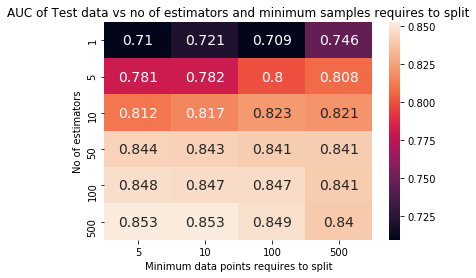

In [55]:
x_label='Minimum data points requires to split'
ylabel='No of estimators'
title= 'AUC of Test data vs no of estimators and minimum samples requires to split'
plot_tables_metrics(test_auc1, min_sample,estimators,x_label,ylabel, title)

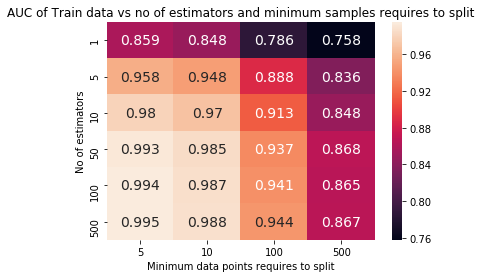

In [56]:
title= 'AUC of Train data vs no of estimators and minimum samples requires to split'
plot_tables_metrics(train_auc1, min_sample,estimators,x_label,ylabel, title)

**Observation**

We can see that when no of Trees are increasing and minimum sample required to spilt is reducing, model is overfitting, hence training auc is increasing but test auc is decreasing. The best no of trees and minimum data point required is 50 and 500 respectively which is giving train and test auc 0.84 and 0.86 respectively, which is very close so our model is well fitting.


In [62]:
from sklearn.ensemble import RandomForestClassifier
estimators=50
best_minm_sampl=500
clf = RandomForestClassifier(criterion='gini', n_estimators=estimators, min_samples_split=best_minm_sampl, n_jobs=-1)
clf.fit(training_count, train_traget)

# Prediction on Test data
pred = clf.predict_proba(test_count)


In [67]:
pred.shape

(20000, 2)

In [72]:
acc = accuracy_score(test_target, pred[:,0].round(), normalize=True) * float(100)
auc=roc_auc_score(test_target, pred[:,1])
print(" estimators: ",estimators," AUC: ",auc)

 estimators:  50  AUC:  0.91335728


In [73]:
# ROC AUC Curve
y_true_train = train_traget
y_probas_train = clf.predict_proba(training_count)
y_true_test = test_target
y_probas_test = clf.predict_proba(test_count)

In [19]:
def plot_train_test_ROC(y_true_train,clf,y_true_test,training_count,test_count):
    # ROC AUC Curve
    y_true_train = train_traget
    y_probas_train = clf.predict_proba(training_count)
    y_true_test = test_target
    y_probas_test = clf.predict_proba(test_count)
    fpr1, tpr1, _ = metrics.roc_curve(y_true_train,  y_probas_train[:,1])
    auc1 = metrics.roc_auc_score(y_true_train, y_probas_train[:,1])
    plt.plot(fpr1,tpr1,label="Train AUC, auc="+str(auc1))
    fpr2, tpr2, _ = metrics.roc_curve(y_true_test,  y_probas_test[:,1])
    auc2 = metrics.roc_auc_score(y_true_test, y_probas_test[:,1])
    plt.plot(fpr2,tpr2,label="Test, auc="+str(auc2))
    plt.legend(loc=4)
    plt.title("Train and Test AUC")
    plt.grid()
    plt.xlabel('False Positive rate')
    plt.ylabel('True positive rate')
    return plt

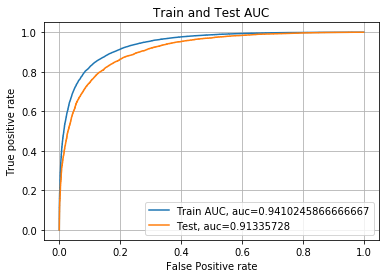

In [75]:
plot_train_test_ROC(y_true_train,clf,y_true_test,training_count,test_count)
plt.show()

**Observation**

We can see that the Train and Test ROC plot is almost overlapping on best hyperparamter no of trees =50 and minm points=500. And the diff of train and Test AUC is minimal so we can say that this model is well fit. If we need better performance than this we may need to try different complex models and add some new features.


In [20]:
# Plotting Confusion matrix on test data
import seaborn as sn
from sklearn.metrics import confusion_matrix

def plotconfusionMatrix(y_true_test,clf,test_count):
    ax= plt.subplot()
    confm = confusion_matrix(y_true_test, clf.predict(test_count))
    sns.heatmap(confm, annot=True, ax = ax,annot_kws={"size": 16},fmt="d"); #annot=True to annotate cells
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix of Test data'); 
    ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1'])

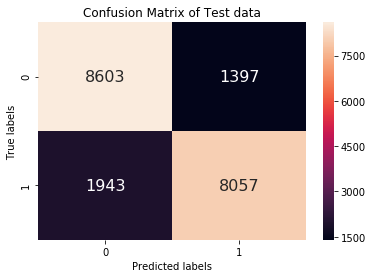

In [77]:
plotconfusionMatrix(y_true_test,clf,test_count)

**Observation**

We can see that on unseen data(Test set) our diagonal elements have more no of count than off diagonals. means we have more TP and TN than FP and FN.If we need better performance than this, i.e to reduce further FP and FN and increase TP and TN then we may need to try different models and add some new features.


### [5.1.2] Wordcloud of top 20 important features from<font color='red'> SET 1</font>

In [78]:
# Please write all the code with proper documentation
feature_data=pd.DataFrame(list(clf.feature_importances_),columns=['gini_importance'])
features=(count_vect.get_feature_names())
feature_data['Feature_name']=features

In [79]:
feature_data.head(2)

,gini_importance,Feature_name
0,0.000299,abl
1,0.000093,absolut


In [80]:
# Important features for both +ve and -ve review
feature_data.sort_values(by='gini_importance',inplace=True,ascending=False)
feature_data.head(20)

,gini_importance,Feature_name
570,0.074967,not
380,0.068826,great
502,0.051545,love
254,0.040645,disappoint
80,0.037582,best
238,0.029609,delici
543,0.018154,money
59,0.017046,bad
627,0.016741,perfect
317,0.016100,favorit


In [21]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

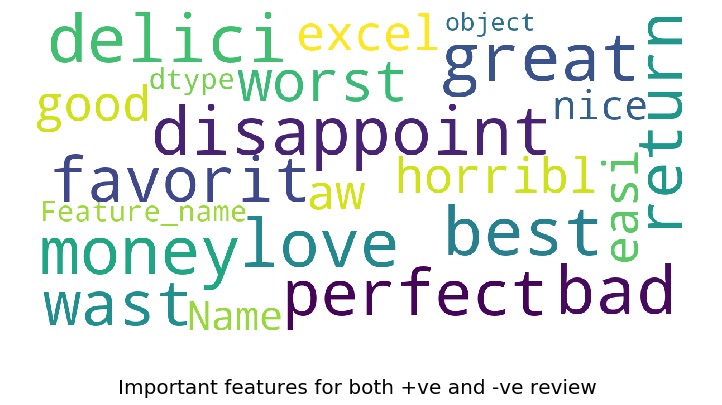

In [82]:
# Word cloud of Important features for both +ve and -ve review
show_wordcloud(str(feature_data['Feature_name'][:20]),"Important features for both +ve and -ve review")

**Observation**

We can see that all the positive and negative words in the above word cloud like amaz, satisfy, delici, disappoint, unfortun so these words are important features for both positive and negative review.


# Feature Engineering

Creating 4 new features using word and character len of description and summary columns


In [83]:
import pandas as pd
data=pd.DataFrame(training_count)
data.head(3)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [84]:
data.shape

(60000, 1000)

In [85]:
#Train data
# word len of description and summary columns
data['description_len'] = train_text_data['CleanedText'].apply(lambda x : len(x.split()))
data['summary_len'] = train_text_data['Summary'].apply(lambda x : len(x.split()))

# charater len of description and summary columns
data['description_char_len'] = train_text_data['CleanedText'].apply(len)
data['Summary_char_len'] = train_text_data['Summary'].apply(len)

In [86]:
data.head(1)

,0,1,2,3,4,5,6,7,8,9,...,994,995,996,997,998,999,description_len,summary_len,description_char_len,Summary_char_len
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,11,1,61,5


In [87]:
data.shape

(60000, 1004)

In [88]:
#Test data
# word len of description and summary columns
data_test=pd.DataFrame(test_count)
data_test['description_len'] = test_text_data['CleanedText'].apply(lambda x : len(x.split()))
data_test['summary_len'] = test_text_data['Summary'].apply(lambda x : len(x.split()))

# charater len of description and summary columns
data_test['description_char_len'] = test_text_data['CleanedText'].apply(len)
data_test['Summary_char_len'] = test_text_data['Summary'].apply(len)
data_test.head(1)

,0,1,2,3,4,5,6,7,8,9,...,994,995,996,997,998,999,description_len,summary_len,description_char_len,Summary_char_len
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,29,2,163,7


In [89]:
data_test.shape

(20000, 1004)

In [91]:
# with new features

estimators=50
best_minm_sampl=500
clf = RandomForestClassifier(criterion='gini', n_estimators=estimators, min_samples_split=best_minm_sampl, n_jobs=-1)
clf.fit(data, train_traget)

# # Prediction on Test data
pred = clf.predict(data_test)
acc = accuracy_score(test_target, pred, normalize=True) * float(100)
auc=roc_auc_score(test_target, pred)
print(" estimators: ",estimators," AUC: ",auc)

 estimators:  50  AUC:  0.83275


**Observation**

After adding the 4 new features, performance has reduced, earlier we have 91% AUC and after feature engineering we are getting 83%, may be we need to tune the hyperparameter further.


# [5.2.1] Applying XGBOOST on BOW, SET 1

In [93]:
# Compute train AUC also

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#Simple Cross Validation
estimators=[1, 5, 10, 50, 100, 500]
learning_rate=[0.0001,0.001,0.01,0.1,1,10,100]
returned_pram1=dict()
returned_pram2=dict()
returned_pram_train1=dict()
returned_pram_train2=dict()
for i in tqdm(estimators):
    for j in tqdm(learning_rate):
        # fit model no training data
        clf = XGBClassifier( learning_rate=j, n_estimators=i, n_jobs=-1, booster='gbtree')

        # fitting the model on crossvalidation train
        clf.fit(training_count, train_traget)
        # predict the response on the crossvalidation train
        pred_cv = clf.predict(cv_count)
        # evaluate CV accuracy
        acc_cv = accuracy_score(cv_target, pred_cv, normalize=True) * float(100)
        auc_cv=roc_auc_score(cv_target, pred_cv)
        auc_train=roc_auc_score(train_traget, clf.predict(training_count))
        print(" No of estimators: ",i," min_sample to break: ",j," AUC: ",auc_cv," Acc: ",acc_cv," auc_train ",auc_train)
        returned_pram1.update({i:auc_cv})
        key= str(i)+" , "+str(j)
        returned_pram2.update({key:auc_cv})
        returned_pram_train1.update({i:auc_train})
        returned_pram_train2.update({key:auc_train})
    gc.collect()

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 No of estimators:  1  min_sample to break:  0.0001  AUC:  0.66955  Acc:  66.955  auc_train  0.6626833333333333



 14%|████████████                                                                        | 1/7 [00:04<00:24,  4.13s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 No of estimators:  1  min_sample to break:  0.001  AUC:  0.66955  Acc:  66.955  auc_train  0.6626833333333333



 29%|████████████████████████                                                            | 2/7 [00:07<00:18,  3.80s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 No of estimators:  1  min_sample to break:  0.01  AUC:  0.66955  Acc:  66.955  auc_train  0.6626833333333333



 43%|████████████████████████████████████                                                | 3/7 [00:10<00:14,  3.58s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 No of estimators:  1  min_sample to break:  0.1  AUC:  0.66955  Acc:  66.955  auc_train  0.6626833333333333



 57%|████████████████████████████████████████████████                                    | 4/7 [00:13<00:10,  3.41s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 No of estimators:  1  min_sample to break:  1  AUC:  0.66955  Acc:  66.955  auc_train  0.6626833333333333



 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:16<00:06,  3.31s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 No of estimators:  1  min_sample to break:  10  AUC:  0.66955  Acc:  66.955  auc_train  0.6626833333333333



 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:19<00:03,  3.21s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 No of estimators:  1  min_sample to break:  100  AUC:  0.66955  Acc:  66.955  auc_train  0.6626833333333333



  0%|                                                                                            | 0/7 [00:00<?, ?it/s]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 No of estimators:  5  min_sample to break:  0.0001  AUC:  0.66955  Acc:  66.955  auc_train  0.6626833333333333



 14%|████████████                                                                        | 1/7 [00:04<00:27,  4.51s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 No of estimators:  5  min_sample to break:  0.001  AUC:  0.66955  Acc:  66.955  auc_train  0.6626833333333333



 29%|████████████████████████                                                            | 2/7 [00:09<00:22,  4.52s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 No of estimators:  5  min_sample to break:  0.01  AUC:  0.66955  Acc:  66.955  auc_train  0.6626833333333333



 43%|████████████████████████████████████                                                | 3/7 [00:13<00:18,  4.58s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 No of estimators:  5  min_sample to break:  0.1  AUC:  0.6826000000000001  Acc:  68.26  auc_train  0.6745166666666668



 57%|████████████████████████████████████████████████                                    | 4/7 [00:18<00:13,  4.65s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 No of estimators:  5  min_sample to break:  1  AUC:  0.7475499999999999  Acc:  74.75500000000001  auc_train  0.743



 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:23<00:09,  4.74s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 No of estimators:  5  min_sample to break:  10  AUC:  0.5  Acc:  50.0  auc_train  0.5



 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:28<00:04,  4.91s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 No of estimators:  5  min_sample to break:  100  AUC:  0.5  Acc:  50.0  auc_train  0.5



  0%|                                                                                            | 0/7 [00:00<?, ?it/s]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 No of estimators:  10  min_sample to break:  0.0001  AUC:  0.66955  Acc:  66.955  auc_train  0.6626833333333333



 14%|████████████                                                                        | 1/7 [00:08<00:50,  8.46s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 No of estimators:  10  min_sample to break:  0.001  AUC:  0.66955  Acc:  66.955  auc_train  0.6626833333333333



 29%|████████████████████████                                                            | 2/7 [00:16<00:42,  8.40s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 No of estimators:  10  min_sample to break:  0.01  AUC:  0.6656  Acc:  66.56  auc_train  0.6579666666666667



 43%|████████████████████████████████████                                                | 3/7 [00:24<00:33,  8.33s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 No of estimators:  10  min_sample to break:  0.1  AUC:  0.70265  Acc:  70.265  auc_train  0.6957166666666666



 57%|████████████████████████████████████████████████                                    | 4/7 [00:33<00:24,  8.30s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 No of estimators:  10  min_sample to break:  1  AUC:  0.7857  Acc:  78.57  auc_train  0.7801499999999999



 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:41<00:16,  8.27s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 No of estimators:  10  min_sample to break:  10  AUC:  0.5  Acc:  50.0  auc_train  0.5



 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:47<00:07,  7.74s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 No of estimators:  10  min_sample to break:  100  AUC:  0.5  Acc:  50.0  auc_train  0.5



  0%|                                                                                            | 0/7 [00:00<?, ?it/s]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 No of estimators:  50  min_sample to break:  0.0001  AUC:  0.66955  Acc:  66.955  auc_train  0.6626833333333333



 14%|████████████                                                                        | 1/7 [00:28<02:50, 28.48s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 No of estimators:  50  min_sample to break:  0.001  AUC:  0.66955  Acc:  66.955  auc_train  0.6626833333333333



 29%|████████████████████████                                                            | 2/7 [00:56<02:21, 28.35s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 No of estimators:  50  min_sample to break:  0.01  AUC:  0.68105  Acc:  68.105  auc_train  0.6734



 43%|████████████████████████████████████                                                | 3/7 [01:24<01:53, 28.30s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 No of estimators:  50  min_sample to break:  0.1  AUC:  0.78035  Acc:  78.035  auc_train  0.7706333333333334



 57%|████████████████████████████████████████████████                                    | 4/7 [01:53<01:25, 28.46s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 No of estimators:  50  min_sample to break:  1  AUC:  0.84405  Acc:  84.405  auc_train  0.8540333333333334



 71%|████████████████████████████████████████████████████████████                        | 5/7 [02:21<00:56, 28.37s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 No of estimators:  50  min_sample to break:  10  AUC:  0.5  Acc:  50.0  auc_train  0.5



 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [02:39<00:25, 25.29s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 No of estimators:  50  min_sample to break:  100  AUC:  0.5  Acc:  50.0  auc_train  0.5



  0%|                                                                                            | 0/7 [00:00<?, ?it/s]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 No of estimators:  100  min_sample to break:  0.0001  AUC:  0.66955  Acc:  66.955  auc_train  0.6626833333333333



 14%|████████████                                                                        | 1/7 [00:53<05:19, 53.23s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 No of estimators:  100  min_sample to break:  0.001  AUC:  0.6656  Acc:  66.56  auc_train  0.6579666666666667



 29%|████████████████████████                                                            | 2/7 [01:46<04:26, 53.24s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 No of estimators:  100  min_sample to break:  0.01  AUC:  0.7028500000000001  Acc:  70.285  auc_train  0.6962333333333335



 43%|████████████████████████████████████                                                | 3/7 [02:39<03:33, 53.30s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 No of estimators:  100  min_sample to break:  0.1  AUC:  0.8161  Acc:  81.61  auc_train  0.8117333333333334



 57%|████████████████████████████████████████████████                                    | 4/7 [03:32<02:39, 53.22s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 No of estimators:  100  min_sample to break:  1  AUC:  0.85645  Acc:  85.64500000000001  auc_train  0.8778000000000001



 71%|████████████████████████████████████████████████████████████                        | 5/7 [04:25<01:46, 53.10s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 No of estimators:  100  min_sample to break:  10  AUC:  0.5  Acc:  50.0  auc_train  0.5



 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [04:58<00:46, 46.95s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 No of estimators:  100  min_sample to break:  100  AUC:  0.5  Acc:  50.0  auc_train  0.5



  0%|                                                                                            | 0/7 [00:00<?, ?it/s]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 No of estimators:  500  min_sample to break:  0.0001  AUC:  0.66955  Acc:  66.955  auc_train  0.6626833333333333



 14%|███████████▊                                                                       | 1/7 [04:12<25:12, 252.01s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 No of estimators:  500  min_sample to break:  0.001  AUC:  0.6810999999999999  Acc:  68.11  auc_train  0.6735166666666667



 29%|███████████████████████▋                                                           | 2/7 [08:27<21:04, 253.00s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 No of estimators:  500  min_sample to break:  0.01  AUC:  0.78805  Acc:  78.805  auc_train  0.7814999999999999



 43%|███████████████████████████████████▌                                               | 3/7 [12:39<16:51, 252.88s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 No of estimators:  500  min_sample to break:  0.1  AUC:  0.8613000000000001  Acc:  86.13  auc_train  0.8701833333333332



 57%|███████████████████████████████████████████████▍                                   | 4/7 [16:52<12:38, 252.85s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 No of estimators:  500  min_sample to break:  1  AUC:  0.86495  Acc:  86.495  auc_train  0.9280666666666667



 71%|███████████████████████████████████████████████████████████▎                       | 5/7 [21:07<08:26, 253.47s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 No of estimators:  500  min_sample to break:  10  AUC:  0.5  Acc:  50.0  auc_train  0.5



 86%|███████████████████████████████████████████████████████████████████████▏           | 6/7 [23:35<03:41, 221.90s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 No of estimators:  500  min_sample to break:  100  AUC:  0.5  Acc:  50.0  auc_train  0.5



100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [36:23<00:00, 576.61s/it]


In [94]:
test_auc=[value for value in returned_pram2.values()]
train_auc=[value for value in returned_pram_train2.values()]
test_auc1=np.reshape(test_auc, (6, 7))
train_auc1=np.reshape(train_auc, (6, 7))

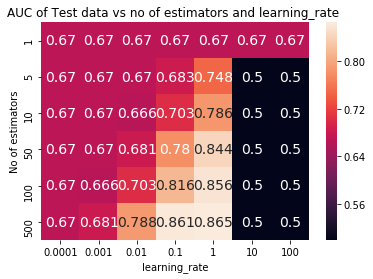

In [95]:
x_label='learning_rate'
ylabel='No of estimators'
title= 'AUC of Test data vs no of estimators and learning_rate '
plot_tables_metrics(test_auc1, learning_rate,estimators,x_label,ylabel, title)

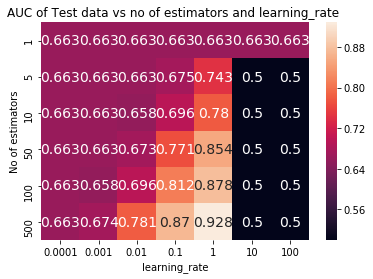

In [96]:
title= 'AUC of Test data vs no of estimators and learning_rate '
plot_tables_metrics(train_auc1, learning_rate,estimators,x_label,ylabel, title)

**Observation**

We can see that when no of Trees are increasing and learning rate is increasing, model is overfitting, hence training auc is increasing but test auc is decreasing. The best no of trees and learning rate is 500 and 0.1 respectively which is giving train and test auc 0.87 and 0.86 respectively, which is very close so our model is well fitting.

Note: As value of learning rate range b/w 0 to 1, model does not perform well either on train and val data with learning rate>1.

In [97]:

estimators=500
learning_rate=0.1
clf = XGBClassifier( learning_rate=learning_rate, n_estimators=estimators, n_jobs=-1, booster='gbtree')
clf.fit(training_count, train_traget)

# Prediction on Test data
pred = clf.predict_proba(test_count)


In [99]:
acc = accuracy_score(test_target, pred[:,0].round(), normalize=True) * float(100)
auc=roc_auc_score(test_target, pred[:,1])
print(" estimators: ",estimators," AUC: ",auc)

 estimators:  500  AUC:  0.92914776


In [100]:
# ROC AUC Curve
y_true_train = train_traget
y_probas_train = clf.predict_proba(training_count)
y_true_test = test_target
y_probas_test = clf.predict_proba(test_count)

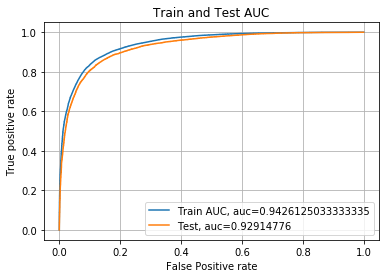

In [101]:
plot_train_test_ROC(y_true_train,clf,y_true_test,training_count,test_count)
plt.show()

**Observation**

We can see that the Train and Test ROC plot is almost overlapping on best hyperparamter no of trees =500 and learning rate =0.1. And the diff of train and Test AUC is minimal so we can say that this model is well fit. If we need better performance than this we may need to try different complex models and add some new features.


C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


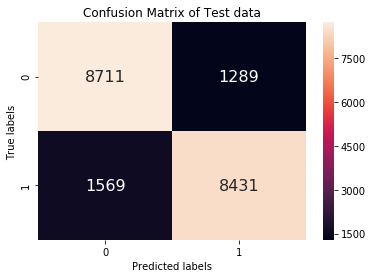

In [102]:
plotconfusionMatrix(y_true_test,clf,test_count)

**Observation**

We can see that on unseen data(Test set) our diagonal elements have more no of count than off diagonals. means we have more TP and TN than FP and FN.If we need better performance than this, i.e to reduce further FP and FN and increase TP and TN then we may need to try different models and add some new features.


# [5.1.2] Wordcloud of top 20 important features from SET 1

In [103]:
# Please write all the code with proper documentation
feature_data=pd.DataFrame(list(clf.feature_importances_),columns=['gini_importance'])
features=(count_vect.get_feature_names())
feature_data['Feature_name']=features

In [104]:
# Important features for both +ve and -ve review
feature_data.sort_values(by='gini_importance',inplace=True,ascending=False)
feature_data.head(20)

,gini_importance,Feature_name
570,0.027318,not
868,0.014821,tast
380,0.012496,great
372,0.012496,good
983,0.009590,would
674,0.008718,product
502,0.008718,love
975,0.008428,wont
254,0.008428,disappoint
80,0.007847,best


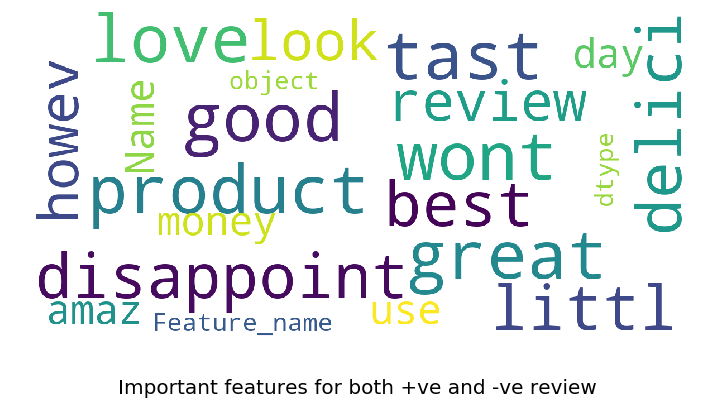

In [105]:
# Word cloud of Important features for both +ve and -ve review
show_wordcloud(str(feature_data['Feature_name'][:20]),"Important features for both +ve and -ve review")

**Observation**

We can see that all the positive and negative words in the above word cloud like amaz, satisfy, delici, disappoint, unfortun so these words are important features for both positive and negative review.


# Feature Engineering

Creating 4 new features using word and character len of description and summary columns


In [106]:
# with new features

estimators=500
learning_rate=0.1
clf = XGBClassifier( learning_rate=learning_rate, n_estimators=estimators, n_jobs=-1, booster='gbtree')
clf.fit(data, train_traget)

# # Prediction on Test data
pred = clf.predict(data_test)
acc = accuracy_score(test_target, pred, normalize=True) * float(100)
auc=roc_auc_score(test_target, pred)
print(" estimators: ",estimators," AUC: ",auc)

C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 estimators:  500  AUC:  0.85735


**Observation**

After adding the 4 new features, performance has reduced, earlier we have 93% AUC and after feature engineering we are getting 85%, may be we need to tune the hyperparameter further.


### [5.1.3] Applying Random Forests on TFIDF,<font color='red'> SET 2</font>

In [9]:
# Please write all the code with proper documentation
tf_idf_vect = TfidfVectorizer(ngram_range=(2,3),min_df=10,max_features=400)
training_counts = tf_idf_vect.fit_transform(train_text_data['CleanedText'])
cv_counts = tf_idf_vect.transform(cv_text_data['CleanedText'])
test_counts = tf_idf_vect.transform(test_text_data['CleanedText'])

In [15]:

print(" training_counts ",training_counts.shape,"cv_counts ",cv_counts.shape,"test_counts",test_counts.shape)
# converting sparse vector to dense vector
training_count=training_counts.toarray()
cv_count=cv_counts.toarray()
test_count=test_counts.toarray()
# removing unused object
gc.collect()

In [12]:
train_traget=train_text_data['Score'].astype('int')
cv_target=cv_text_data['Score'].astype('int')
test_target=test_text_data['Score'].astype('int')

In [14]:
# Compute train AUC also

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#Simple Cross Validation
estimators=[1, 5, 10, 50, 100, 500]
min_sample=[5, 10, 100, 500]
returned_pram1=dict()
returned_pram2=dict()
returned_pram_train1=dict()
returned_pram_train2=dict()
for i in tqdm(estimators):
    for j in tqdm(min_sample):
        # instantiate learning model
        clf = RandomForestClassifier(criterion='gini', n_estimators=i,min_samples_split=j,max_features='sqrt',n_jobs=-1)
        # fitting the model on crossvalidation train
        clf.fit(training_count, train_traget)
        # predict the response on the crossvalidation train
        pred_cv = clf.predict(cv_count)
        # evaluate CV accuracy
        acc_cv = accuracy_score(cv_target, pred_cv, normalize=True) * float(100)
        auc_cv=roc_auc_score(cv_target, pred_cv)
        auc_train=roc_auc_score(train_traget, clf.predict(training_count))
        print(" depth value: ",i," min_sample to break: ",j," AUC: ",auc_cv," Acc: ",acc_cv," auc_train ",auc_train)
        returned_pram1.update({i:auc_cv})
        key= str(i)+" , "+str(j)
        returned_pram2.update({key:auc_cv})
        returned_pram_train1.update({i:auc_train})
        returned_pram_train2.update({key:auc_train})
    gc.collect()

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

 depth value:  1  min_sample to break:  5  AUC:  0.6885  Acc:  68.85  auc_train  0.7862166666666668



 25%|█████████████████████                                                               | 1/4 [00:01<00:05,  1.98s/it]

 depth value:  1  min_sample to break:  10  AUC:  0.6933  Acc:  69.33  auc_train  0.7815333333333334



 50%|██████████████████████████████████████████                                          | 2/4 [00:03<00:03,  1.93s/it]

 depth value:  1  min_sample to break:  100  AUC:  0.70915  Acc:  70.91499999999999  auc_train  0.7590166666666667



 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:05<00:01,  1.89s/it]

 depth value:  1  min_sample to break:  500  AUC:  0.70915  Acc:  70.91499999999999  auc_train  0.7389166666666666



  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

 depth value:  5  min_sample to break:  5  AUC:  0.7167  Acc:  71.67  auc_train  0.8292333333333333



 25%|█████████████████████                                                               | 1/4 [00:03<00:09,  3.32s/it]

 depth value:  5  min_sample to break:  10  AUC:  0.7162000000000001  Acc:  71.61999999999999  auc_train  0.8266



 50%|██████████████████████████████████████████                                          | 2/4 [00:06<00:06,  3.32s/it]

 depth value:  5  min_sample to break:  100  AUC:  0.719  Acc:  71.89999999999999  auc_train  0.7892333333333333



 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:09<00:03,  3.29s/it]

 depth value:  5  min_sample to break:  500  AUC:  0.7254499999999999  Acc:  72.545  auc_train  0.7592333333333333



  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

 depth value:  10  min_sample to break:  5  AUC:  0.7175  Acc:  71.75  auc_train  0.8411



 25%|█████████████████████                                                               | 1/4 [00:06<00:19,  6.41s/it]

 depth value:  10  min_sample to break:  10  AUC:  0.7246  Acc:  72.46000000000001  auc_train  0.83735



 50%|██████████████████████████████████████████                                          | 2/4 [00:12<00:12,  6.39s/it]

 depth value:  10  min_sample to break:  100  AUC:  0.7258999999999999  Acc:  72.59  auc_train  0.7980833333333333



 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:19<00:06,  6.35s/it]

 depth value:  10  min_sample to break:  500  AUC:  0.7265  Acc:  72.65  auc_train  0.7634166666666666



  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

 depth value:  50  min_sample to break:  5  AUC:  0.72585  Acc:  72.585  auc_train  0.8513666666666666



 25%|█████████████████████                                                               | 1/4 [00:31<01:34, 31.38s/it]

 depth value:  50  min_sample to break:  10  AUC:  0.72675  Acc:  72.675  auc_train  0.8483833333333333



 50%|██████████████████████████████████████████                                          | 2/4 [01:02<01:02, 31.36s/it]

 depth value:  50  min_sample to break:  100  AUC:  0.7296499999999999  Acc:  72.965  auc_train  0.8047



 75%|███████████████████████████████████████████████████████████████                     | 3/4 [01:30<00:30, 30.23s/it]

 depth value:  50  min_sample to break:  500  AUC:  0.7303499999999999  Acc:  73.03500000000001  auc_train  0.7651500000000001



  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

 depth value:  100  min_sample to break:  5  AUC:  0.7269000000000001  Acc:  72.69  auc_train  0.8524166666666667



 25%|█████████████████████                                                               | 1/4 [01:00<03:01, 60.66s/it]

 depth value:  100  min_sample to break:  10  AUC:  0.7264999999999999  Acc:  72.65  auc_train  0.8497833333333333



 50%|██████████████████████████████████████████                                          | 2/4 [02:00<02:00, 60.40s/it]

 depth value:  100  min_sample to break:  100  AUC:  0.73055  Acc:  73.055  auc_train  0.8055500000000001



 75%|███████████████████████████████████████████████████████████████                     | 3/4 [02:55<00:58, 58.72s/it]

 depth value:  100  min_sample to break:  500  AUC:  0.7297  Acc:  72.97  auc_train  0.7658666666666667



  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

 depth value:  500  min_sample to break:  5  AUC:  0.7277000000000001  Acc:  72.77  auc_train  0.8534



 25%|████████████████████▊                                                              | 1/4 [04:18<12:54, 258.02s/it]

 depth value:  500  min_sample to break:  10  AUC:  0.7278  Acc:  72.78  auc_train  0.8507166666666668



 50%|█████████████████████████████████████████▌                                         | 2/4 [08:28<08:31, 255.64s/it]

 depth value:  500  min_sample to break:  100  AUC:  0.7306499999999999  Acc:  73.065  auc_train  0.8060000000000002



 75%|██████████████████████████████████████████████████████████████▎                    | 3/4 [12:34<04:12, 252.93s/it]

 depth value:  500  min_sample to break:  500  AUC:  0.73005  Acc:  73.005  auc_train  0.7663833333333333



100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [23:17<00:00, 370.73s/it]


In [16]:
test_auc=[value for value in returned_pram2.values()]
train_auc=[value for value in returned_pram_train2.values()]
test_auc1=np.reshape(test_auc, (6, 4))
train_auc1=np.reshape(train_auc, (6, 4))

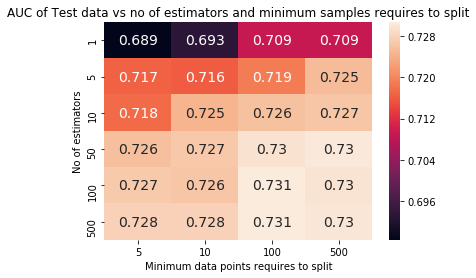

In [22]:
x_label='Minimum data points requires to split'
ylabel='No of estimators'
title= 'AUC of Test data vs no of estimators and minimum samples requires to split'
plot_tables_metrics(test_auc1, min_sample,estimators,x_label,ylabel, title)

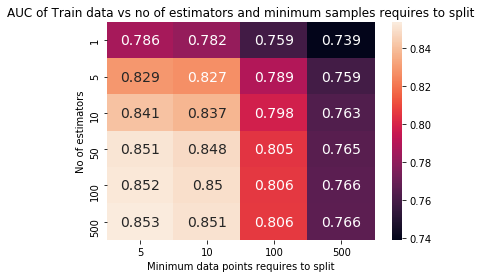

In [23]:
title= 'AUC of Train data vs no of estimators and minimum samples requires to split'
plot_tables_metrics(train_auc1, min_sample,estimators,x_label,ylabel, title)

**Observation**

We can see that when no of Trees are increasing and minimum sample required to spilt is reducing, model is overfitting, hence training auc is increasing but test auc is decreasing. The best no of trees and minimum data point required is 50 and 500 respectively which is giving train and test auc 0.84 and 0.86 respectively, which is very close so our model is well fitting.

In [24]:
from sklearn.ensemble import RandomForestClassifier
estimators=50
best_minm_sampl=500
clf = RandomForestClassifier(criterion='gini', n_estimators=estimators, min_samples_split=best_minm_sampl, n_jobs=-1)
clf.fit(training_count, train_traget)

# Prediction on Test data
pred = clf.predict_proba(test_count)


In [25]:
acc = accuracy_score(test_target, pred[:,0].round(), normalize=True) * float(100)
auc=roc_auc_score(test_target, pred[:,1])
print(" estimators: ",estimators," AUC: ",auc)

 estimators:  50  AUC:  0.8152944900000001


In [27]:
# ROC AUC Curve
y_true_train = train_traget
y_probas_train = clf.predict_proba(training_count)
y_true_test = test_target
y_probas_test = clf.predict_proba(test_count)

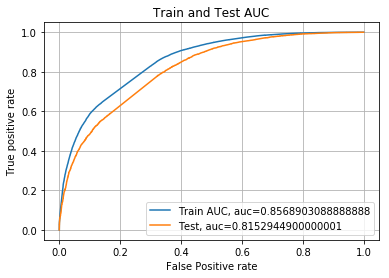

In [28]:
plot_train_test_ROC(y_true_train,clf,y_true_test,training_count,test_count)
plt.show()

**Observation**

We can see that the Train and Test ROC plot is almost overlapping on best hyperparamter no of trees =50 and minm points=500. And the diff of train and Test AUC is minimal so we can say that this model is well fit. If we need better performance than this we may need to try different complex models and add some new features.

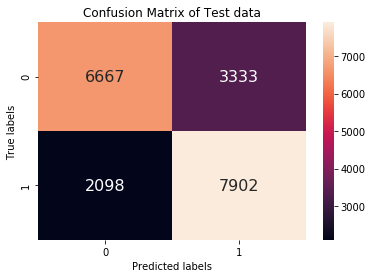

In [29]:
plotconfusionMatrix(y_true_test,clf,test_count)

**Observation**
We can see that on unseen data(Test set) our diagonal elements have more no of count than off diagonals. means we have more TP and TN than FP and FN.If we need better performance than this, i.e to reduce further FP and FN and increase TP and TN then we may need to try different models and add some new features.

### [5.1.4] Wordcloud of top 20 important features from<font color='red'> SET 2</font>

In [31]:

# Please write all the code with proper documentation
feature_data=pd.DataFrame(list(clf.feature_importances_),columns=['gini_importance'])
features=(tf_idf_vect.get_feature_names())
feature_data['Feature_name']=features

In [32]:
# Important features for both +ve and -ve review
feature_data.sort_values(by='gini_importance',inplace=True,ascending=False)
feature_data.head(20)

,gini_importance,Feature_name
358,0.042934,veri disappoint
154,0.036285,high recommend
224,0.033254,not buy
374,0.030800,wast money
324,0.026900,tast like
250,0.022357,not worth
393,0.020120,would not
381,0.016136,wont buy
323,0.015128,tast great
232,0.014985,not good


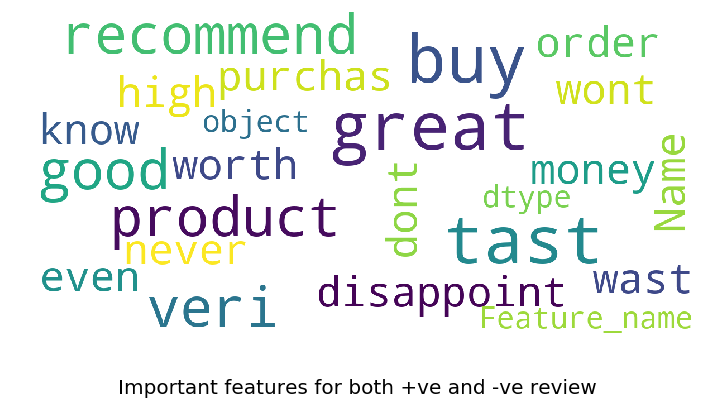

In [33]:
# Word cloud of Important features for both +ve and -ve review
show_wordcloud(str(feature_data['Feature_name'][:20]),"Important features for both +ve and -ve review")

**Observation**

We can see that all the positive and negative words in the above word cloud like amaz, satisfy, delici, disappoint, unfortun so these words are important features for both positive and negative review.

# Feature Engineering

Creating 4 new features using word and character len of description and summary columns


In [34]:
import pandas as pd
data=pd.DataFrame(training_count)
data.head(3)

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
#Train data
# word len of description and summary columns
data['description_len'] = train_text_data['CleanedText'].apply(lambda x : len(x.split()))
data['summary_len'] = train_text_data['Summary'].apply(lambda x : len(x.split()))

# charater len of description and summary columns
data['description_char_len'] = train_text_data['CleanedText'].apply(len)
data['Summary_char_len'] = train_text_data['Summary'].apply(len)

In [36]:
#Test data
# word len of description and summary columns
data_test=pd.DataFrame(test_count)
data_test['description_len'] = test_text_data['CleanedText'].apply(lambda x : len(x.split()))
data_test['summary_len'] = test_text_data['Summary'].apply(lambda x : len(x.split()))

# charater len of description and summary columns
data_test['description_char_len'] = test_text_data['CleanedText'].apply(len)
data_test['Summary_char_len'] = test_text_data['Summary'].apply(len)
data_test.head(1)

,0,1,2,3,4,5,6,7,8,9,...,394,395,396,397,398,399,description_len,summary_len,description_char_len,Summary_char_len
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,29,2,163,7


In [38]:
# with new features

estimators=50
best_minm_sampl=500
clf = RandomForestClassifier(criterion='gini', n_estimators=estimators, min_samples_split=best_minm_sampl, n_jobs=-1)
clf.fit(data, train_traget)

# # Prediction on Test data
pred = clf.predict(data_test)
acc = accuracy_score(test_target, pred, normalize=True) * float(100)
auc=roc_auc_score(test_target, pred)
print(" estimators: ",estimators," AUC: ",auc)

 estimators:  50  AUC:  0.7266999999999999


**Observation**

After adding the 4 new features, performance has reduced, earlier we have 80% AUC and after feature engineering we are getting 72%, may be we need to tune the hyperparameter further.

# [5.2.2] Applying XGBOOST on TFIDF, SET 2

In [40]:
# Compute train AUC also

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#Simple Cross Validation
estimators=[1, 5, 10, 50, 100, 500]
learning_rate=[0.0001,0.001,0.01,0.1,1,10,100]
returned_pram1=dict()
returned_pram2=dict()
returned_pram_train1=dict()
returned_pram_train2=dict()
for i in tqdm(estimators):
    for j in tqdm(learning_rate):
        # instantiate learning model
        clf = XGBClassifier( learning_rate=j, n_estimators=i, n_jobs=-1, booster='gbtree')
        # fitting the model on crossvalidation train
        clf.fit(training_count, train_traget)
        # predict the response on the crossvalidation train
        pred_cv = clf.predict(cv_count)
        # evaluate CV accuracy
        acc_cv = accuracy_score(cv_target, pred_cv, normalize=True) * float(100)
        auc_cv=roc_auc_score(cv_target, pred_cv)
        auc_train=roc_auc_score(train_traget, clf.predict(training_count))
        print(" depth value: ",i," min_sample to break: ",j," AUC: ",auc_cv," Acc: ",acc_cv," auc_train ",auc_train)
        returned_pram1.update({i:auc_cv})
        key= str(i)+" , "+str(j)
        returned_pram2.update({key:auc_cv})
        returned_pram_train1.update({i:auc_train})
        returned_pram_train2.update({key:auc_train})
    gc.collect()

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  1  min_sample to break:  0.0001  AUC:  0.53965  Acc:  53.964999999999996  auc_train  0.5348999999999999



 14%|████████████                                                                        | 1/7 [00:02<00:16,  2.75s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  1  min_sample to break:  0.001  AUC:  0.53965  Acc:  53.964999999999996  auc_train  0.5348999999999999



 29%|████████████████████████                                                            | 2/7 [00:04<00:11,  2.32s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  1  min_sample to break:  0.01  AUC:  0.53965  Acc:  53.964999999999996  auc_train  0.5348999999999999



 43%|████████████████████████████████████                                                | 3/7 [00:05<00:08,  2.03s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  1  min_sample to break:  0.1  AUC:  0.53965  Acc:  53.964999999999996  auc_train  0.5348999999999999



 57%|████████████████████████████████████████████████                                    | 4/7 [00:06<00:05,  1.82s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  1  min_sample to break:  1  AUC:  0.53965  Acc:  53.964999999999996  auc_train  0.5348999999999999



 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:08<00:03,  1.70s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  1  min_sample to break:  10  AUC:  0.53965  Acc:  53.964999999999996  auc_train  0.5348999999999999



 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:09<00:01,  1.60s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  1  min_sample to break:  100  AUC:  0.53965  Acc:  53.964999999999996  auc_train  0.5348999999999999



  0%|                                                                                            | 0/7 [00:00<?, ?it/s]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  5  min_sample to break:  0.0001  AUC:  0.53965  Acc:  53.964999999999996  auc_train  0.5348333333333333



 14%|████████████                                                                        | 1/7 [00:01<00:11,  1.93s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  5  min_sample to break:  0.001  AUC:  0.55765  Acc:  55.765  auc_train  0.5512166666666667



 29%|████████████████████████                                                            | 2/7 [00:03<00:09,  1.97s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  5  min_sample to break:  0.01  AUC:  0.55765  Acc:  55.765  auc_train  0.5512833333333333



 43%|████████████████████████████████████                                                | 3/7 [00:06<00:08,  2.03s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  5  min_sample to break:  0.1  AUC:  0.5923  Acc:  59.230000000000004  auc_train  0.5854666666666667



 57%|████████████████████████████████████████████████                                    | 4/7 [00:08<00:05,  1.99s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  5  min_sample to break:  1  AUC:  0.6344000000000001  Acc:  63.44  auc_train  0.6272833333333334



 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:10<00:03,  1.98s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  5  min_sample to break:  10  AUC:  0.5  Acc:  50.0  auc_train  0.5



 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:11<00:01,  1.94s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  5  min_sample to break:  100  AUC:  0.5  Acc:  50.0  auc_train  0.5



  0%|                                                                                            | 0/7 [00:00<?, ?it/s]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  10  min_sample to break:  0.0001  AUC:  0.53965  Acc:  53.964999999999996  auc_train  0.5348333333333333



 14%|████████████                                                                        | 1/7 [00:02<00:16,  2.76s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  10  min_sample to break:  0.001  AUC:  0.55765  Acc:  55.765  auc_train  0.5512166666666667



 29%|████████████████████████                                                            | 2/7 [00:05<00:14,  2.82s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  10  min_sample to break:  0.01  AUC:  0.55765  Acc:  55.765  auc_train  0.5512833333333333



 43%|████████████████████████████████████                                                | 3/7 [00:08<00:11,  2.90s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  10  min_sample to break:  0.1  AUC:  0.6003000000000001  Acc:  60.029999999999994  auc_train  0.5939000000000001



 57%|████████████████████████████████████████████████                                    | 4/7 [00:11<00:08,  2.87s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  10  min_sample to break:  1  AUC:  0.6563000000000001  Acc:  65.63  auc_train  0.65015



 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:14<00:05,  2.90s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  10  min_sample to break:  10  AUC:  0.5  Acc:  50.0  auc_train  0.5



 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:17<00:02,  2.78s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  10  min_sample to break:  100  AUC:  0.5  Acc:  50.0  auc_train  0.5



  0%|                                                                                            | 0/7 [00:00<?, ?it/s]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  50  min_sample to break:  0.0001  AUC:  0.55765  Acc:  55.765  auc_train  0.5512166666666667



 14%|████████████                                                                        | 1/7 [00:13<01:20, 13.48s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  50  min_sample to break:  0.001  AUC:  0.55765  Acc:  55.765  auc_train  0.5512166666666667



 29%|████████████████████████                                                            | 2/7 [00:26<01:07, 13.41s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  50  min_sample to break:  0.01  AUC:  0.5923999999999999  Acc:  59.24  auc_train  0.5855



 43%|████████████████████████████████████                                                | 3/7 [00:39<00:53, 13.27s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  50  min_sample to break:  0.1  AUC:  0.6646  Acc:  66.46  auc_train  0.658



 57%|████████████████████████████████████████████████                                    | 4/7 [00:52<00:39, 13.20s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  50  min_sample to break:  1  AUC:  0.7240000000000001  Acc:  72.39999999999999  auc_train  0.7281166666666667



 71%|████████████████████████████████████████████████████████████                        | 5/7 [01:05<00:26, 13.19s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  50  min_sample to break:  10  AUC:  0.5  Acc:  50.0  auc_train  0.5



 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [01:14<00:11, 11.90s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  50  min_sample to break:  100  AUC:  0.5  Acc:  50.0  auc_train  0.5



  0%|                                                                                            | 0/7 [00:00<?, ?it/s]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  100  min_sample to break:  0.0001  AUC:  0.55765  Acc:  55.765  auc_train  0.5512166666666667



 14%|████████████                                                                        | 1/7 [00:24<02:28, 24.70s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  100  min_sample to break:  0.001  AUC:  0.55765  Acc:  55.765  auc_train  0.5512166666666667



 29%|████████████████████████                                                            | 2/7 [00:46<01:59, 23.93s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  100  min_sample to break:  0.01  AUC:  0.6000500000000001  Acc:  60.004999999999995  auc_train  0.5935833333333334



 43%|████████████████████████████████████                                                | 3/7 [01:09<01:34, 23.52s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  100  min_sample to break:  0.1  AUC:  0.6873499999999999  Acc:  68.735  auc_train  0.6841333333333334



 57%|████████████████████████████████████████████████                                    | 4/7 [01:31<01:09, 23.05s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  100  min_sample to break:  1  AUC:  0.7339500000000001  Acc:  73.395  auc_train  0.7465666666666666



 71%|████████████████████████████████████████████████████████████                        | 5/7 [01:53<00:45, 22.71s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  100  min_sample to break:  10  AUC:  0.5  Acc:  50.0  auc_train  0.5



 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [02:06<00:19, 19.98s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  100  min_sample to break:  100  AUC:  0.5  Acc:  50.0  auc_train  0.5



  0%|                                                                                            | 0/7 [00:00<?, ?it/s]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  500  min_sample to break:  0.0001  AUC:  0.55765  Acc:  55.765  auc_train  0.5512166666666667



 14%|███████████▊                                                                       | 1/7 [01:43<10:22, 103.73s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  500  min_sample to break:  0.001  AUC:  0.5923999999999999  Acc:  59.24  auc_train  0.5855



 29%|███████████████████████▋                                                           | 2/7 [03:27<08:38, 103.80s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  500  min_sample to break:  0.01  AUC:  0.66065  Acc:  66.065  auc_train  0.6547499999999999



 43%|███████████████████████████████████▌                                               | 3/7 [05:10<06:54, 103.62s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  500  min_sample to break:  0.1  AUC:  0.7295  Acc:  72.95  auc_train  0.7363666666666666



 57%|███████████████████████████████████████████████▍                                   | 4/7 [06:54<05:10, 103.53s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  500  min_sample to break:  1  AUC:  0.72785  Acc:  72.785  auc_train  0.7798999999999999



 71%|███████████████████████████████████████████████████████████▎                       | 5/7 [08:37<03:26, 103.48s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  500  min_sample to break:  10  AUC:  0.5  Acc:  50.0  auc_train  0.5



 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [09:39<01:30, 90.92s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  500  min_sample to break:  100  AUC:  0.5  Acc:  50.0  auc_train  0.5



100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [15:08<00:00, 238.75s/it]


In [41]:
test_auc=[value for value in returned_pram2.values()]
train_auc=[value for value in returned_pram_train2.values()]
test_auc1=np.reshape(test_auc, (6, 7))
train_auc1=np.reshape(train_auc, (6, 7))

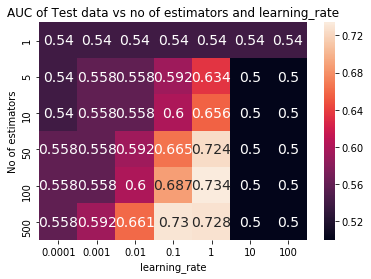

In [46]:
x_label='learning_rate'
ylabel='No of estimators'
title= 'AUC of Test data vs no of estimators and learning_rate'
plot_tables_metrics(test_auc1, learning_rate,estimators,x_label,ylabel, title)

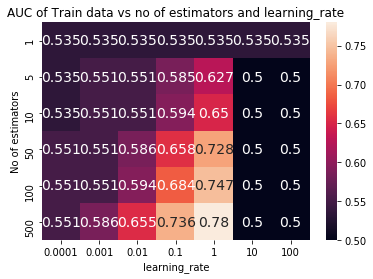

In [47]:
title= 'AUC of Train data vs no of estimators and learning_rate'
plot_tables_metrics(train_auc1, learning_rate,estimators,x_label,ylabel, title)

**Observation**

We can see that when no of Trees are increasing and minimum sample required to spilt is reducing, model is overfitting, hence training auc is increasing but test auc is decreasing. The best no of trees and learning rate is 100 and 0.1 respectively which is giving train and test auc 0.73 and 0.74 respectively, which is very close so our model is well fitting.

Note: As value of learning rate range b/w 0 to 1, model does not perform well either on train and val data with learning rate>1.

In [48]:
estimators=100
learning_rate=1
clf = XGBClassifier( learning_rate=learning_rate, n_estimators=estimators, n_jobs=-1, booster='gbtree')
clf.fit(training_count, train_traget)

# Prediction on Test data
pred = clf.predict_proba(test_count)


In [49]:
acc = accuracy_score(test_target, pred[:,0].round(), normalize=True) * float(100)
auc=roc_auc_score(test_target, pred[:,1])
print(" estimators: ",estimators," AUC: ",auc)

 estimators:  100  AUC:  0.8201233099999999


In [50]:
# ROC AUC Curve
y_true_train = train_traget
y_probas_train = clf.predict_proba(training_count)
y_true_test = test_target
y_probas_test = clf.predict_proba(test_count)

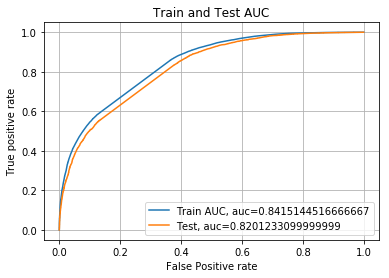

In [51]:
plot_train_test_ROC(y_true_train,clf,y_true_test,training_count,test_count)
plt.show()

Observation

We can see that the Train and Test ROC plot is almost overlapping on best hyperparamter no of trees =100 and learning rate=1. And the diff of train and Test AUC is minimal so we can say that this model is well fit. If we need better performance than this we may need to try different complex models and add some new features.

C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


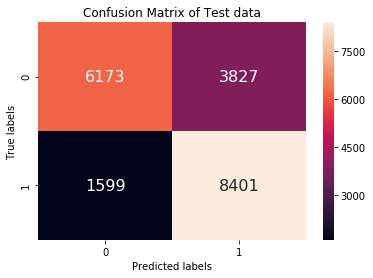

In [52]:

plotconfusionMatrix(y_true_test,clf,test_count)

**Observation**

We can see that on unseen data(Test set) our diagonal elements have more no of count than off diagonals. means we have more TP and TN than FP and FN.If we need better performance than this, i.e to reduce further FP and FN and increase TP and TN then we may need to try different models and add some new features.

In [53]:

# Please write all the code with proper documentation
feature_data=pd.DataFrame(list(clf.feature_importances_),columns=['gini_importance'])
features=(tf_idf_vect.get_feature_names())
feature_data['Feature_name']=features

In [54]:
# Important features for both +ve and -ve review
feature_data.sort_values(by='gini_importance',inplace=True,ascending=False)
feature_data.head(20)

,gini_importance,Feature_name
324,0.031509,tast like
166,0.014925,ive tri
68,0.014925,dog love
138,0.011609,great price
243,0.011609,not sure
189,0.009950,long time
144,0.009950,groceri store
360,0.009950,veri good
322,0.009950,tast good
74,0.009950,dont know


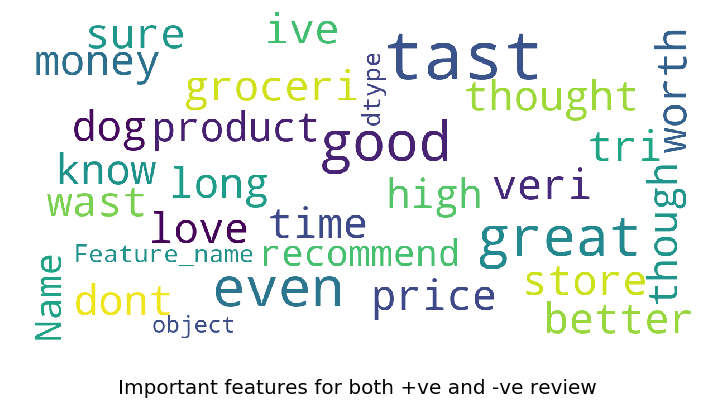

In [55]:
# Word cloud of Important features for both +ve and -ve review
show_wordcloud(str(feature_data['Feature_name'][:20]),"Important features for both +ve and -ve review")

**Observation**

We can see that all the positive and negative words in the above word cloud like amaz, satisfy, delici, disappoint, unfortun so these words are important features for both positive and negative review.

# Feature Engineering

Creating 4 new features using word and character len of description and summary columns


In [56]:
# with new features

estimators=100
learning_rate=1
clf = XGBClassifier( learning_rate=learning_rate, n_estimators=estimators, n_jobs=-1, booster='gbtree')
clf.fit(data, train_traget)

# # Prediction on Test data
pred = clf.predict(data_test)
acc = accuracy_score(test_target, pred, normalize=True) * float(100)
auc=roc_auc_score(test_target, pred)
print(" estimators: ",estimators," AUC: ",auc)

C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 estimators:  100  AUC:  0.7283000000000001


**Observation**

After adding the 4 new features, performance has reduced, earlier we have 80% AUC and after feature engineering we are getting 72%, may be we need to tune the hyperparameter further.

### [5.1.5] Applying Random Forests on AVG W2V,<font color='red'> SET 3</font>

In [57]:
# Please write all the code with proper documentation

# Please write all the code with proper documentation
#train_avg_w2v_data,cv_avg_w2v_data,test_avg_w2v_data
train_traget=train_avg_w2v_data['Score'].astype('int')
cv_target=cv_avg_w2v_data['Score'].astype('int')
test_target=test_avg_w2v_data['Score'].astype('int')

train_data = train_avg_w2v_data.iloc[:,:-2]
cv_data = cv_avg_w2v_data.iloc[:,:-2]
test_data = test_avg_w2v_data.iloc[:,:-2]

In [58]:
train_avg_w2v_data.head(1)

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,Score,Time
18000,-0.072261,-0.631519,1.198363,0.29545,0.123251,-1.53865,0.494211,0.498906,-0.04214,-0.516918,...,0.558099,-0.098661,-0.087573,1.054245,1.093834,0.375699,0.012794,0.076482,0.0,948240000.0


In [59]:
# Compute train AUC also

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#Simple Cross Validation
estimators=[1, 5, 10, 50, 100, 500]
min_sample=[5, 10, 100, 500]
returned_pram1=dict()
returned_pram2=dict()
returned_pram_train1=dict()
returned_pram_train2=dict()
for i in tqdm(estimators):
    for j in tqdm(min_sample):
        # instantiate learning model
        clf = RandomForestClassifier(criterion='gini', n_estimators=i,min_samples_split=j,max_features='sqrt',n_jobs=-1)
        # fitting the model on crossvalidation train
        clf.fit(train_data, train_traget)
        # predict the response on the crossvalidation train
        pred_cv = clf.predict(cv_data)
        # evaluate CV accuracy
        acc_cv = accuracy_score(cv_target, pred_cv, normalize=True) * float(100)
        auc_cv=roc_auc_score(cv_target, pred_cv)
        auc_train=roc_auc_score(train_traget, clf.predict(train_data))
        print(" depth value: ",i," min_sample to break: ",j," AUC: ",auc_cv," Acc: ",acc_cv," auc_train ",auc_train)
        returned_pram1.update({i:auc_cv})
        key= str(i)+" , "+str(j)
        returned_pram2.update({key:auc_cv})
        returned_pram_train1.update({i:auc_train})
        returned_pram_train2.update({key:auc_train})
    gc.collect()

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

 depth value:  1  min_sample to break:  5  AUC:  0.49916666666666676  Acc:  49.916666666666664  auc_train  0.7913055555555557



 25%|█████████████████████                                                               | 1/4 [00:01<00:03,  1.33s/it]

 depth value:  1  min_sample to break:  10  AUC:  0.5111666666666668  Acc:  51.11666666666667  auc_train  0.7526944444444444



 50%|██████████████████████████████████████████                                          | 2/4 [00:01<00:02,  1.08s/it]

 depth value:  1  min_sample to break:  100  AUC:  0.499  Acc:  49.9  auc_train  0.6047222222222222



 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:02<00:00,  1.10it/s]

 depth value:  1  min_sample to break:  500  AUC:  0.49841666666666673  Acc:  49.84166666666667  auc_train  0.5502499999999999



  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

 depth value:  5  min_sample to break:  5  AUC:  0.5044166666666667  Acc:  50.44166666666666  auc_train  0.9393888888888889



 25%|█████████████████████                                                               | 1/4 [00:01<00:03,  1.04s/it]

 depth value:  5  min_sample to break:  10  AUC:  0.5010833333333333  Acc:  50.108333333333334  auc_train  0.9132777777777777



 50%|██████████████████████████████████████████                                          | 2/4 [00:02<00:02,  1.02s/it]

 depth value:  5  min_sample to break:  100  AUC:  0.5034166666666667  Acc:  50.34166666666666  auc_train  0.7104166666666667



 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:02<00:00,  1.00it/s]

 depth value:  5  min_sample to break:  500  AUC:  0.5036666666666667  Acc:  50.366666666666674  auc_train  0.611638888888889



  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

 depth value:  10  min_sample to break:  5  AUC:  0.49416666666666664  Acc:  49.416666666666664  auc_train  0.9833888888888889



 25%|█████████████████████                                                               | 1/4 [00:01<00:03,  1.26s/it]

 depth value:  10  min_sample to break:  10  AUC:  0.5114166666666667  Acc:  51.141666666666666  auc_train  0.9713888888888889



 50%|██████████████████████████████████████████                                          | 2/4 [00:02<00:02,  1.25s/it]

 depth value:  10  min_sample to break:  100  AUC:  0.49341666666666667  Acc:  49.34166666666667  auc_train  0.7791111111111111



 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:03<00:01,  1.21s/it]

 depth value:  10  min_sample to break:  500  AUC:  0.49941666666666673  Acc:  49.94166666666667  auc_train  0.6489999999999999



  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

 depth value:  50  min_sample to break:  5  AUC:  0.5005  Acc:  50.05  auc_train  0.9998888888888889



 25%|█████████████████████                                                               | 1/4 [00:04<00:12,  4.16s/it]

 depth value:  50  min_sample to break:  10  AUC:  0.50275  Acc:  50.275000000000006  auc_train  0.9998611111111111



 50%|██████████████████████████████████████████                                          | 2/4 [00:08<00:08,  4.20s/it]

 depth value:  50  min_sample to break:  100  AUC:  0.5077499999999999  Acc:  50.775000000000006  auc_train  0.9345277777777778



 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:12<00:04,  4.07s/it]

 depth value:  50  min_sample to break:  500  AUC:  0.5074166666666666  Acc:  50.74166666666666  auc_train  0.7504722222222222



  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

 depth value:  100  min_sample to break:  5  AUC:  0.49966666666666665  Acc:  49.96666666666666  auc_train  0.9998888888888889



 25%|█████████████████████                                                               | 1/4 [00:08<00:25,  8.35s/it]

 depth value:  100  min_sample to break:  10  AUC:  0.5076666666666666  Acc:  50.76666666666667  auc_train  0.9998888888888889



 50%|██████████████████████████████████████████                                          | 2/4 [00:16<00:16,  8.35s/it]

 depth value:  100  min_sample to break:  100  AUC:  0.5075833333333333  Acc:  50.75833333333334  auc_train  0.9673333333333333



 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:23<00:07,  7.94s/it]

 depth value:  100  min_sample to break:  500  AUC:  0.5048333333333334  Acc:  50.483333333333334  auc_train  0.78475



  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

 depth value:  500  min_sample to break:  5  AUC:  0.50775  Acc:  50.775000000000006  auc_train  0.999888888888889



 25%|█████████████████████                                                               | 1/4 [00:41<02:05, 41.99s/it]

 depth value:  500  min_sample to break:  10  AUC:  0.5097499999999999  Acc:  50.975  auc_train  0.999888888888889



 50%|██████████████████████████████████████████                                          | 2/4 [01:22<01:22, 41.45s/it]

 depth value:  500  min_sample to break:  100  AUC:  0.5165833333333333  Acc:  51.65833333333333  auc_train  0.9908055555555555



 75%|███████████████████████████████████████████████████████████████                     | 3/4 [01:56<00:39, 39.44s/it]

 depth value:  500  min_sample to break:  500  AUC:  0.5154166666666666  Acc:  51.541666666666664  auc_train  0.82675



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [03:25<00:00, 54.12s/it]


In [60]:
test_auc=[value for value in returned_pram2.values()]
train_auc=[value for value in returned_pram_train2.values()]
test_auc1=np.reshape(test_auc, (6, 4))
train_auc1=np.reshape(train_auc, (6, 4))

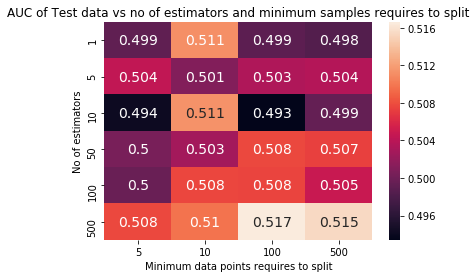

In [61]:
x_label='Minimum data points requires to split'
ylabel='No of estimators'
title= 'AUC of Test data vs no of estimators and minimum samples requires to split'
plot_tables_metrics(test_auc1, min_sample,estimators,x_label,ylabel, title)

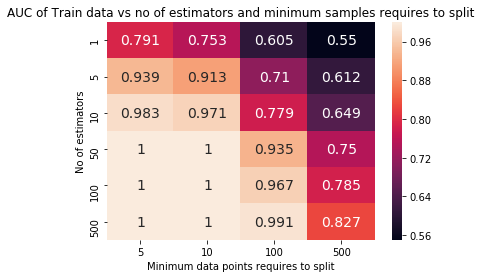

In [62]:
title= 'AUC of Train data vs no of estimators and minimum samples requires to split'
plot_tables_metrics(train_auc1, min_sample,estimators,x_label,ylabel, title)

**Observation**
We can see that when no of trees are increasing and minimum sample required to spilt is reducing, model is overfitting, hence training auc is increasing but test auc is decreasing. The best tree depth and minimum data point required is 5 and 500 respectively which is giving train and test auc 0.54 and 0.50 respectively, which is very close so our model is well fitting.


In [65]:
from sklearn.ensemble import RandomForestClassifier
estimators=5
best_minm_sampl=500
clf = RandomForestClassifier(criterion='gini', n_estimators=estimators, min_samples_split=best_minm_sampl, n_jobs=-1)
clf.fit(train_data, train_traget)

# Prediction on Test data
pred = clf.predict_proba(test_data)


In [66]:
acc = accuracy_score(test_target, pred[:,0].round(), normalize=True) * float(100)
auc=roc_auc_score(test_target, pred[:,1])
print(" estimators: ",estimators," AUC: ",auc)

 estimators:  5  AUC:  0.497705375


In [67]:
# ROC AUC Curve
y_true_train = train_traget
y_probas_train = clf.predict_proba(train_data)
y_true_test = test_target
y_probas_test = clf.predict_proba(test_data)

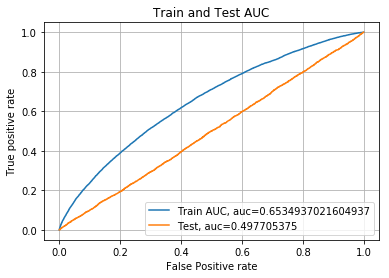

In [69]:
plot_train_test_ROC(y_true_train,clf,y_true_test,train_data,test_data)
plt.show()

**Observation**

We can see that the Train and Test ROC plot is bit overlapping on best no of tress =5 and minm points=500. And the diff of train and Test AUC is minimal but overall auc is low so we can say that this model is underfitting . If we need better performance than this we may need to try different complex models and add some new features.


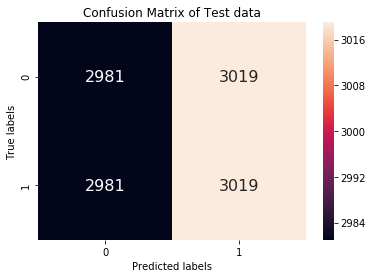

In [70]:
plotconfusionMatrix(y_true_test,clf,test_data)

Observation

We can see that on unseen data(Test set) our diagonal elements have almost similar number than off diagonal with very high no of FP and FN, ie. model is underfitting.If we need better performance than this, i.e to reduce further FP and FN and increase TP and TN then we may need to add some new features.


In [71]:
# Compute train AUC also

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#Simple Cross Validation
estimators=[1, 5, 10, 50, 100, 500]
learning_rate=[0.0001,0.001,0.01,0.1,1,10,100]
returned_pram1=dict()
returned_pram2=dict()
returned_pram_train1=dict()
returned_pram_train2=dict()
for i in tqdm(estimators):
    for j in tqdm(learning_rate):
        # instantiate learning model
        clf = XGBClassifier( learning_rate=j, n_estimators=i, n_jobs=-1, booster='gbtree')
        # fitting the model on crossvalidation train
        clf.fit(train_data, train_traget)
        # predict the response on the crossvalidation train
        pred_cv = clf.predict(cv_data)
        # evaluate CV accuracy
        acc_cv = accuracy_score(cv_target, pred_cv, normalize=True) * float(100)
        auc_cv=roc_auc_score(cv_target, pred_cv)
        auc_train=roc_auc_score(train_traget, clf.predict(train_data))
        print(" depth value: ",i," min_sample to break: ",j," AUC: ",auc_cv," Acc: ",acc_cv," auc_train ",auc_train)
        returned_pram1.update({i:auc_cv})
        key= str(i)+" , "+str(j)
        returned_pram2.update({key:auc_cv})
        returned_pram_train1.update({i:auc_train})
        returned_pram_train2.update({key:auc_train})
    gc.collect()

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  1  min_sample to break:  0.0001  AUC:  0.502  Acc:  50.2  auc_train  0.510888888888889



 14%|████████████                                                                        | 1/7 [00:01<00:07,  1.18s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  1  min_sample to break:  0.001  AUC:  0.502  Acc:  50.2  auc_train  0.510888888888889



 29%|████████████████████████                                                            | 2/7 [00:01<00:04,  1.10it/s]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  1  min_sample to break:  0.01  AUC:  0.502  Acc:  50.2  auc_train  0.510888888888889



 43%|████████████████████████████████████                                                | 3/7 [00:01<00:02,  1.39it/s]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  1  min_sample to break:  0.1  AUC:  0.502  Acc:  50.2  auc_train  0.510888888888889



 57%|████████████████████████████████████████████████                                    | 4/7 [00:02<00:01,  1.72it/s]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  1  min_sample to break:  1  AUC:  0.502  Acc:  50.2  auc_train  0.510888888888889



 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:02<00:00,  2.05it/s]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  1  min_sample to break:  10  AUC:  0.502  Acc:  50.2  auc_train  0.510888888888889



 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:02<00:00,  2.34it/s]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  1  min_sample to break:  100  AUC:  0.502  Acc:  50.2  auc_train  0.510888888888889



  0%|                                                                                            | 0/7 [00:00<?, ?it/s]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  5  min_sample to break:  0.0001  AUC:  0.502  Acc:  50.2  auc_train  0.510888888888889



 14%|████████████                                                                        | 1/7 [00:00<00:02,  2.49it/s]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  5  min_sample to break:  0.001  AUC:  0.502  Acc:  50.2  auc_train  0.510888888888889



 29%|████████████████████████                                                            | 2/7 [00:00<00:02,  2.40it/s]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  5  min_sample to break:  0.01  AUC:  0.497  Acc:  49.7  auc_train  0.516888888888889



 43%|████████████████████████████████████                                                | 3/7 [00:01<00:01,  2.34it/s]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  5  min_sample to break:  0.1  AUC:  0.5005833333333333  Acc:  50.05833333333334  auc_train  0.52725



 57%|████████████████████████████████████████████████                                    | 4/7 [00:01<00:01,  2.35it/s]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  5  min_sample to break:  1  AUC:  0.5137499999999999  Acc:  51.37500000000001  auc_train  0.53225



 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:02<00:00,  2.37it/s]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  5  min_sample to break:  10  AUC:  0.5  Acc:  50.0  auc_train  0.5



 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:02<00:00,  2.46it/s]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  5  min_sample to break:  100  AUC:  0.5  Acc:  50.0  auc_train  0.5



  0%|                                                                                            | 0/7 [00:00<?, ?it/s]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  10  min_sample to break:  0.0001  AUC:  0.502  Acc:  50.2  auc_train  0.510888888888889



 14%|████████████                                                                        | 1/7 [00:00<00:03,  1.65it/s]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  10  min_sample to break:  0.001  AUC:  0.4980833333333333  Acc:  49.80833333333333  auc_train  0.5128055555555556



 29%|████████████████████████                                                            | 2/7 [00:01<00:03,  1.66it/s]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  10  min_sample to break:  0.01  AUC:  0.4994166666666667  Acc:  49.94166666666667  auc_train  0.5214166666666666



 43%|████████████████████████████████████                                                | 3/7 [00:01<00:02,  1.62it/s]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  10  min_sample to break:  0.1  AUC:  0.5058333333333332  Acc:  50.583333333333336  auc_train  0.5372499999999999



 57%|████████████████████████████████████████████████                                    | 4/7 [00:02<00:01,  1.63it/s]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  10  min_sample to break:  1  AUC:  0.5070833333333333  Acc:  50.708333333333336  auc_train  0.5455833333333334



 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:03<00:01,  1.64it/s]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  10  min_sample to break:  10  AUC:  0.5004166666666667  Acc:  50.041666666666664  auc_train  0.5001111111111112



 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:03<00:00,  1.80it/s]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  10  min_sample to break:  100  AUC:  0.5  Acc:  50.0  auc_train  0.5



  0%|                                                                                            | 0/7 [00:00<?, ?it/s]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  50  min_sample to break:  0.0001  AUC:  0.502  Acc:  50.2  auc_train  0.510888888888889



 14%|████████████                                                                        | 1/7 [00:02<00:14,  2.42s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  50  min_sample to break:  0.001  AUC:  0.49649999999999994  Acc:  49.65  auc_train  0.5192500000000001



 29%|████████████████████████                                                            | 2/7 [00:04<00:11,  2.36s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  50  min_sample to break:  0.01  AUC:  0.5006666666666667  Acc:  50.06666666666667  auc_train  0.5308055555555555



 43%|████████████████████████████████████                                                | 3/7 [00:06<00:09,  2.32s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  50  min_sample to break:  0.1  AUC:  0.5048333333333332  Acc:  50.483333333333334  auc_train  0.5699722222222222



 57%|████████████████████████████████████████████████                                    | 4/7 [00:09<00:06,  2.31s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  50  min_sample to break:  1  AUC:  0.5086666666666667  Acc:  50.866666666666674  auc_train  0.6065277777777778



 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:11<00:04,  2.28s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  50  min_sample to break:  10  AUC:  0.5  Acc:  50.0  auc_train  0.5



 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:12<00:01,  1.85s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  50  min_sample to break:  100  AUC:  0.5  Acc:  50.0  auc_train  0.5



  0%|                                                                                            | 0/7 [00:00<?, ?it/s]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  100  min_sample to break:  0.0001  AUC:  0.4980833333333333  Acc:  49.80833333333333  auc_train  0.5128055555555556



 14%|████████████                                                                        | 1/7 [00:04<00:25,  4.28s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  100  min_sample to break:  0.001  AUC:  0.49975  Acc:  49.975  auc_train  0.5241666666666667



 29%|████████████████████████                                                            | 2/7 [00:08<00:21,  4.29s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  100  min_sample to break:  0.01  AUC:  0.5090833333333333  Acc:  50.90833333333333  auc_train  0.542611111111111



 43%|████████████████████████████████████                                                | 3/7 [00:12<00:17,  4.28s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  100  min_sample to break:  0.1  AUC:  0.5045833333333333  Acc:  50.458333333333336  auc_train  0.596388888888889



 57%|████████████████████████████████████████████████                                    | 4/7 [00:16<00:12,  4.24s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  100  min_sample to break:  1  AUC:  0.507  Acc:  50.7  auc_train  0.6536111111111111



 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:21<00:08,  4.27s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  100  min_sample to break:  10  AUC:  0.5  Acc:  50.0  auc_train  0.5



 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:22<00:03,  3.42s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  100  min_sample to break:  100  AUC:  0.5  Acc:  50.0  auc_train  0.5



  0%|                                                                                            | 0/7 [00:00<?, ?it/s]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  500  min_sample to break:  0.0001  AUC:  0.49741666666666673  Acc:  49.74166666666667  auc_train  0.51825



 14%|████████████                                                                        | 1/7 [00:20<02:03, 20.65s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  500  min_sample to break:  0.001  AUC:  0.5015000000000001  Acc:  50.14999999999999  auc_train  0.5329722222222222



 29%|████████████████████████                                                            | 2/7 [00:44<01:47, 21.60s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  500  min_sample to break:  0.01  AUC:  0.5070833333333333  Acc:  50.708333333333336  auc_train  0.5738888888888889



 43%|████████████████████████████████████                                                | 3/7 [01:08<01:29, 22.42s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  500  min_sample to break:  0.1  AUC:  0.5043333333333333  Acc:  50.43333333333333  auc_train  0.6994999999999999



 57%|████████████████████████████████████████████████                                    | 4/7 [01:33<01:09, 23.20s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  500  min_sample to break:  1  AUC:  0.5076666666666667  Acc:  50.76666666666667  auc_train  0.8477777777777777



 71%|████████████████████████████████████████████████████████████                        | 5/7 [01:58<00:47, 23.74s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  500  min_sample to break:  10  AUC:  0.5  Acc:  50.0  auc_train  0.5



 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [02:06<00:18, 18.84s/it]C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


 depth value:  500  min_sample to break:  100  AUC:  0.5  Acc:  50.0  auc_train  0.5



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [03:00<00:00, 48.14s/it]


In [72]:
test_auc=[value for value in returned_pram2.values()]
train_auc=[value for value in returned_pram_train2.values()]
test_auc1=np.reshape(test_auc, (6, 7))
train_auc1=np.reshape(train_auc, (6, 7))

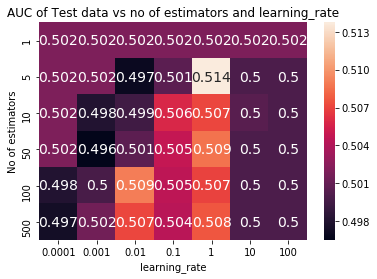

In [73]:
x_label='learning_rate'
ylabel='No of estimators'
title= 'AUC of Test data vs no of estimators and learning_rate'
plot_tables_metrics(test_auc1, learning_rate,estimators,x_label,ylabel, title)

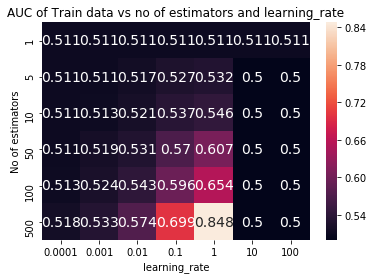

In [74]:
title= 'AUC of Train data vs no of estimators and learning_rate'
plot_tables_metrics(train_auc1, learning_rate,estimators,x_label,ylabel, title)

**Observation**

We can see that when no of tress are increasing and learning_rate is increasing, model is overfitting, hence training auc is increasing but test auc is decreasing. The best tree depth and minimum data point required is 1 and 1 respectively which is giving train and test auc 0.54 and 0.50 respectively, which is very close so our model is well fitting.

Note: As value of learning rate range b/w 0 to 1, model does not perform well either on train and val data with learning rate>1.

In [75]:

estimators=5
learning_rate=1
clf = XGBClassifier( learning_rate=learning_rate, n_estimators=estimators, n_jobs=-1, booster='gbtree')
clf.fit(train_data, train_traget)

# Prediction on Test data
pred = clf.predict_proba(test_data)


In [76]:
acc = accuracy_score(test_target, pred[:,0].round(), normalize=True) * float(100)
auc=roc_auc_score(test_target, pred[:,1])
print(" estimators: ",estimators," AUC: ",auc)

 estimators:  5  AUC:  0.4989934583333333


In [77]:
# ROC AUC Curve
y_true_train = train_traget
y_probas_train = clf.predict_proba(train_data)
y_true_test = test_target
y_probas_test = clf.predict_proba(test_data)

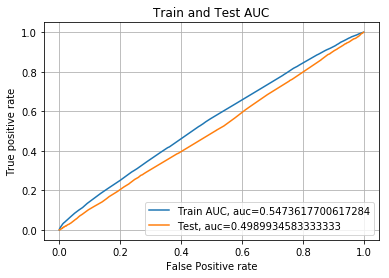

In [78]:
plot_train_test_ROC(y_true_train,clf,y_true_test,train_data,test_data)
plt.show()

**Observation**

We can see that the Train and Test ROC plot is bit overlapping on best no of trees =5 and learning rate=1. And the diff of train and Test AUC is minimal but overall auc is low so we can say that this model is underfitting . If we need better performance than this we may need to try different complex models and add some new features.

C:\Users\Sanjay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


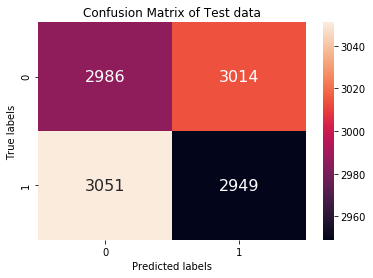

In [79]:

plotconfusionMatrix(y_true_test,clf,test_data)

**Observation**

We can see that on unseen data(Test set) our diagonal elements have almost similar number than off diagonal with very high no of FP and FN, ie. model is underfitting.If we need better performance than this, i.e to reduce further FP and FN and increase TP and TN then we may need to add some new features.

### [5.1.6] Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

In [81]:
# Please write all the code with proper documentation


In [82]:
# Please write all the code with proper documentation
#train_avg_w2v_data,cv_avg_w2v_data,test_avg_w2v_data
train_traget=train_tfidf_w2v_data['Score'].astype('int')
cv_target=cv_tfidf_w2v_data['Score'].astype('int')
test_target=test_tfidf_w2v_data['Score'].astype('int')

train_data = train_tfidf_w2v_data.iloc[:,:-2]
cv_data = cv_tfidf_w2v_data.iloc[:,:-2]
test_data = test_tfidf_w2v_data.iloc[:,:-2]

In [83]:
# Compute train AUC also

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#Simple Cross Validation
estimators=[1, 5, 10, 50, 100, 500]
min_sample=[5, 10, 100, 500]
returned_pram1=dict()
returned_pram2=dict()
returned_pram_train1=dict()
returned_pram_train2=dict()
for i in tqdm(estimators):
    for j in tqdm(min_sample):
        # instantiate learning model
        clf = RandomForestClassifier(criterion='gini', n_estimators=i,min_samples_split=j,max_features='sqrt',n_jobs=-1)
        # fitting the model on crossvalidation train
        clf.fit(train_data, train_traget)
        # predict the response on the crossvalidation train
        pred_cv = clf.predict(cv_data)
        # evaluate CV accuracy
        acc_cv = accuracy_score(cv_target, pred_cv, normalize=True) * float(100)
        auc_cv=roc_auc_score(cv_target, pred_cv)
        auc_train=roc_auc_score(train_traget, clf.predict(train_data))
        print(" depth value: ",i," min_sample to break: ",j," AUC: ",auc_cv," Acc: ",acc_cv," auc_train ",auc_train)
        returned_pram1.update({i:auc_cv})
        key= str(i)+" , "+str(j)
        returned_pram2.update({key:auc_cv})
        returned_pram_train1.update({i:auc_train})
        returned_pram_train2.update({key:auc_train})
    gc.collect()

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

 depth value:  1  min_sample to break:  5  AUC:  0.5063333333333333  Acc:  50.63333333333333  auc_train  0.7922222222222223



 25%|█████████████████████                                                               | 1/4 [00:01<00:03,  1.22s/it]

 depth value:  1  min_sample to break:  10  AUC:  0.5044166666666667  Acc:  50.44166666666666  auc_train  0.756388888888889



 50%|██████████████████████████████████████████                                          | 2/4 [00:01<00:02,  1.03s/it]

 depth value:  1  min_sample to break:  100  AUC:  0.50425  Acc:  50.425  auc_train  0.6021388888888889



 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:02<00:00,  1.15it/s]

 depth value:  1  min_sample to break:  500  AUC:  0.5100833333333332  Acc:  51.00833333333333  auc_train  0.545888888888889



  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

 depth value:  5  min_sample to break:  5  AUC:  0.5018333333333334  Acc:  50.18333333333334  auc_train  0.9355555555555556



 25%|█████████████████████                                                               | 1/4 [00:00<00:02,  1.05it/s]

 depth value:  5  min_sample to break:  10  AUC:  0.499  Acc:  49.9  auc_train  0.9117500000000001



 50%|██████████████████████████████████████████                                          | 2/4 [00:01<00:01,  1.05it/s]

 depth value:  5  min_sample to break:  100  AUC:  0.5134166666666666  Acc:  51.34166666666666  auc_train  0.7085277777777779



 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:02<00:00,  1.09it/s]

 depth value:  5  min_sample to break:  500  AUC:  0.4944166666666666  Acc:  49.44166666666667  auc_train  0.60875



  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

 depth value:  10  min_sample to break:  5  AUC:  0.494  Acc:  49.4  auc_train  0.9832222222222222



 25%|█████████████████████                                                               | 1/4 [00:01<00:04,  1.50s/it]

 depth value:  10  min_sample to break:  10  AUC:  0.5084166666666666  Acc:  50.84166666666666  auc_train  0.9695555555555556



 50%|██████████████████████████████████████████                                          | 2/4 [00:02<00:02,  1.44s/it]

 depth value:  10  min_sample to break:  100  AUC:  0.50375  Acc:  50.375  auc_train  0.7793611111111112



 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:04<00:01,  1.44s/it]

 depth value:  10  min_sample to break:  500  AUC:  0.5018333333333334  Acc:  50.18333333333334  auc_train  0.6454722222222222



  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

 depth value:  50  min_sample to break:  5  AUC:  0.5043333333333333  Acc:  50.43333333333333  auc_train  0.9998333333333334



 25%|█████████████████████                                                               | 1/4 [00:04<00:14,  4.77s/it]

 depth value:  50  min_sample to break:  10  AUC:  0.5066666666666666  Acc:  50.66666666666667  auc_train  0.9996666666666666



 50%|██████████████████████████████████████████                                          | 2/4 [00:09<00:09,  4.71s/it]

 depth value:  50  min_sample to break:  100  AUC:  0.5079166666666666  Acc:  50.79166666666667  auc_train  0.9246388888888888



 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:13<00:04,  4.43s/it]

 depth value:  50  min_sample to break:  500  AUC:  0.5148333333333333  Acc:  51.483333333333334  auc_train  0.7439444444444445



  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

 depth value:  100  min_sample to break:  5  AUC:  0.5066666666666666  Acc:  50.66666666666667  auc_train  0.999888888888889



 25%|█████████████████████                                                               | 1/4 [00:08<00:26,  8.67s/it]

 depth value:  100  min_sample to break:  10  AUC:  0.5070833333333333  Acc:  50.708333333333336  auc_train  0.9998888888888889



 50%|██████████████████████████████████████████                                          | 2/4 [00:17<00:17,  8.64s/it]

 depth value:  100  min_sample to break:  100  AUC:  0.514  Acc:  51.4  auc_train  0.9584166666666667



 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:24<00:08,  8.33s/it]

 depth value:  100  min_sample to break:  500  AUC:  0.5040833333333333  Acc:  50.40833333333333  auc_train  0.780888888888889



  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

 depth value:  500  min_sample to break:  5  AUC:  0.5168333333333333  Acc:  51.68333333333334  auc_train  0.9998888888888889



 25%|█████████████████████                                                               | 1/4 [00:41<02:03, 41.24s/it]

 depth value:  500  min_sample to break:  10  AUC:  0.51675  Acc:  51.675000000000004  auc_train  0.9998888888888889



 50%|██████████████████████████████████████████                                          | 2/4 [01:22<01:22, 41.12s/it]

 depth value:  500  min_sample to break:  100  AUC:  0.5104166666666666  Acc:  51.041666666666664  auc_train  0.9814444444444446



 75%|███████████████████████████████████████████████████████████████                     | 3/4 [01:57<00:39, 39.54s/it]

 depth value:  500  min_sample to break:  500  AUC:  0.5150833333333333  Acc:  51.50833333333333  auc_train  0.8226666666666668



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [03:28<00:00, 54.74s/it]


In [84]:
test_auc=[value for value in returned_pram2.values()]
train_auc=[value for value in returned_pram_train2.values()]
test_auc1=np.reshape(test_auc, (6, 4))
train_auc1=np.reshape(train_auc, (6, 4))

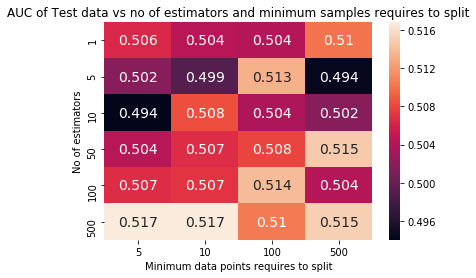

In [85]:
x_label='Minimum data points requires to split'
ylabel='No of estimators'
title= 'AUC of Test data vs no of estimators and minimum samples requires to split'
plot_tables_metrics(test_auc1, min_sample,estimators,x_label,ylabel, title)

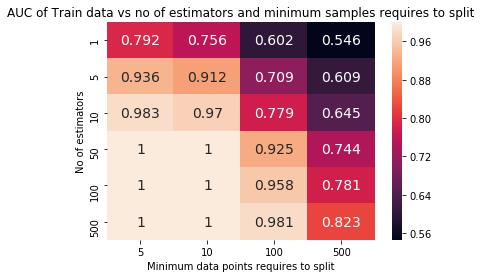

In [86]:
title= 'AUC of Train data vs no of estimators and minimum samples requires to split'
plot_tables_metrics(train_auc1, min_sample,estimators,x_label,ylabel, title)

**Observation** 

We can see that when no of trees are increasing and minimum sample required to spilt is reducing, model is overfitting, hence training auc is increasing but test auc is decreasing. The best tree depth and minimum data point required is 10 and 500 respectively which is giving train and test auc 0.54 and 0.50 respectively, which is very close so our model is well fitting.

In [87]:
from sklearn.ensemble import RandomForestClassifier
estimators=10
best_minm_sampl=500
clf = RandomForestClassifier(criterion='gini', n_estimators=estimators, min_samples_split=best_minm_sampl, n_jobs=-1)
clf.fit(train_data, train_traget)

# Prediction on Test data
pred = clf.predict_proba(test_data)


In [88]:
acc = accuracy_score(test_target, pred[:,0].round(), normalize=True) * float(100)
auc=roc_auc_score(test_target, pred[:,1])
print(" estimators: ",estimators," AUC: ",auc)

 estimators:  10  AUC:  0.4922295277777778


In [89]:
# ROC AUC Curve
y_true_train = train_traget
y_probas_train = clf.predict_proba(train_data)
y_true_test = test_target
y_probas_test = clf.predict_proba(test_data)

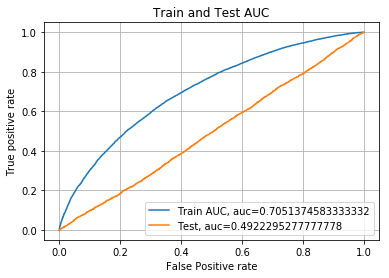

In [90]:
plot_train_test_ROC(y_true_train,clf,y_true_test,train_data,test_data)
plt.show()

**Observation**

We can see that the Train and Test ROC plot is bit overlapping on best no of tress =10 and minm points=500. And the diff of train and Test AUC is minimal but overall auc is low so we can say that this model is underfitting . If we need better performance than this we may need to try different complex models and add some new features.

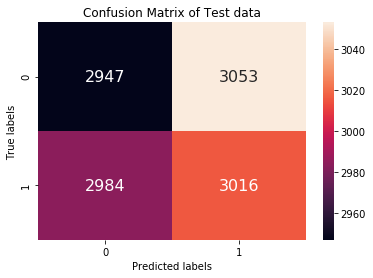

In [91]:
plotconfusionMatrix(y_true_test,clf,test_data)

**Observation**
We can see that on unseen data(Test set) our diagonal elements have almost similar number than off diagonal with very high no of FP and FN, ie. model is underfitting.If we need better performance than this, i.e to reduce further FP and FN and increase TP and TN then we may need to add some new features.

In [92]:
# Compute train AUC also

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#Simple Cross Validation
estimators=[1, 5, 10, 50, 100, 500]
learning_rate=[0.0001,0.001,0.01,0.1,1,10,100]
returned_pram1=dict()
returned_pram2=dict()
returned_pram_train1=dict()
returned_pram_train2=dict()
for i in tqdm(estimators):
    for j in tqdm(learning_rate):
        # instantiate learning model
        clf = XGBClassifier( learning_rate=j, n_estimators=i, n_jobs=-1, booster='gbtree')
        # fitting the model on crossvalidation train
        clf.fit(train_data, train_traget)
        # predict the response on the crossvalidation train
        pred_cv = clf.predict(cv_data)
        # evaluate CV accuracy
        acc_cv = accuracy_score(cv_target, pred_cv, normalize=True) * float(100)
        auc_cv=roc_auc_score(cv_target, pred_cv)
        auc_train=roc_auc_score(train_traget, clf.predict(train_data))
        print(" depth value: ",i," min_sample to break: ",j," AUC: ",auc_cv," Acc: ",acc_cv," auc_train ",auc_train)
        returned_pram1.update({i:auc_cv})
        key= str(i)+" , "+str(j)
        returned_pram2.update({key:auc_cv})
        returned_pram_train1.update({i:auc_train})
        returned_pram_train2.update({key:auc_train})
    gc.collect()

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

 depth value:  1  min_sample to break:  0.0001  AUC:  0.5009166666666667  Acc:  50.09166666666667  auc_train  0.5130555555555556



 14%|████████████                                                                        | 1/7 [00:01<00:09,  1.56s/it]

 depth value:  1  min_sample to break:  0.001  AUC:  0.5009166666666667  Acc:  50.09166666666667  auc_train  0.5130555555555556



 29%|████████████████████████                                                            | 2/7 [00:01<00:05,  1.17s/it]

 depth value:  1  min_sample to break:  0.01  AUC:  0.5009166666666667  Acc:  50.09166666666667  auc_train  0.5130555555555556



 43%|████████████████████████████████████                                                | 3/7 [00:02<00:03,  1.11it/s]

 depth value:  1  min_sample to break:  0.1  AUC:  0.5009166666666667  Acc:  50.09166666666667  auc_train  0.5130555555555556



 57%|████████████████████████████████████████████████                                    | 4/7 [00:02<00:02,  1.39it/s]

 depth value:  1  min_sample to break:  1  AUC:  0.5009166666666667  Acc:  50.09166666666667  auc_train  0.5130555555555556



 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:02<00:01,  1.71it/s]

 depth value:  1  min_sample to break:  10  AUC:  0.5009166666666667  Acc:  50.09166666666667  auc_train  0.5130555555555556



 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:02<00:00,  2.03it/s]

 depth value:  1  min_sample to break:  100  AUC:  0.5009166666666667  Acc:  50.09166666666667  auc_train  0.5130555555555556



  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

 depth value:  5  min_sample to break:  0.0001  AUC:  0.5009166666666667  Acc:  50.09166666666667  auc_train  0.5130555555555556



 14%|████████████                                                                        | 1/7 [00:00<00:02,  2.44it/s]

 depth value:  5  min_sample to break:  0.001  AUC:  0.501  Acc:  50.1  auc_train  0.513



 29%|████████████████████████                                                            | 2/7 [00:00<00:02,  2.43it/s]

 depth value:  5  min_sample to break:  0.01  AUC:  0.5028333333333334  Acc:  50.28333333333334  auc_train  0.5152222222222222



 43%|████████████████████████████████████                                                | 3/7 [00:01<00:01,  2.43it/s]

 depth value:  5  min_sample to break:  0.1  AUC:  0.5095  Acc:  50.949999999999996  auc_train  0.5231666666666667



 57%|████████████████████████████████████████████████                                    | 4/7 [00:01<00:01,  2.41it/s]

 depth value:  5  min_sample to break:  1  AUC:  0.5055833333333333  Acc:  50.55833333333334  auc_train  0.5265833333333333



 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:02<00:00,  2.40it/s]

 depth value:  5  min_sample to break:  10  AUC:  0.5  Acc:  50.0  auc_train  0.5



 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:02<00:00,  2.50it/s]

 depth value:  5  min_sample to break:  100  AUC:  0.5  Acc:  50.0  auc_train  0.5



  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

 depth value:  10  min_sample to break:  0.0001  AUC:  0.5009166666666667  Acc:  50.09166666666667  auc_train  0.5130555555555556



 14%|████████████                                                                        | 1/7 [00:00<00:03,  1.63it/s]

 depth value:  10  min_sample to break:  0.001  AUC:  0.501  Acc:  50.1  auc_train  0.513



 29%|████████████████████████                                                            | 2/7 [00:01<00:03,  1.63it/s]

 depth value:  10  min_sample to break:  0.01  AUC:  0.50875  Acc:  50.875  auc_train  0.5164444444444445



 43%|████████████████████████████████████                                                | 3/7 [00:01<00:02,  1.64it/s]

 depth value:  10  min_sample to break:  0.1  AUC:  0.5118333333333334  Acc:  51.18333333333334  auc_train  0.5370277777777778



 57%|████████████████████████████████████████████████                                    | 4/7 [00:02<00:01,  1.65it/s]

 depth value:  10  min_sample to break:  1  AUC:  0.5051666666666668  Acc:  50.516666666666666  auc_train  0.5408888888888889



 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:03<00:01,  1.65it/s]

 depth value:  10  min_sample to break:  10  AUC:  0.5  Acc:  50.0  auc_train  0.5



 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:03<00:00,  1.83it/s]

 depth value:  10  min_sample to break:  100  AUC:  0.5  Acc:  50.0  auc_train  0.5



  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

 depth value:  50  min_sample to break:  0.0001  AUC:  0.501  Acc:  50.1  auc_train  0.513



 14%|████████████                                                                        | 1/7 [00:02<00:13,  2.20s/it]

 depth value:  50  min_sample to break:  0.001  AUC:  0.5028333333333334  Acc:  50.28333333333334  auc_train  0.5152222222222222



 29%|████████████████████████                                                            | 2/7 [00:04<00:11,  2.23s/it]

 depth value:  50  min_sample to break:  0.01  AUC:  0.5039166666666667  Acc:  50.391666666666666  auc_train  0.528



 43%|████████████████████████████████████                                                | 3/7 [00:06<00:08,  2.23s/it]

 depth value:  50  min_sample to break:  0.1  AUC:  0.5079166666666668  Acc:  50.79166666666667  auc_train  0.5673055555555556



 57%|████████████████████████████████████████████████                                    | 4/7 [00:08<00:06,  2.20s/it]

 depth value:  50  min_sample to break:  1  AUC:  0.5074166666666666  Acc:  50.74166666666666  auc_train  0.6039166666666667



 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:11<00:04,  2.24s/it]

 depth value:  50  min_sample to break:  10  AUC:  0.5  Acc:  50.0  auc_train  0.5



 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:12<00:01,  1.83s/it]

 depth value:  50  min_sample to break:  100  AUC:  0.5  Acc:  50.0  auc_train  0.5



  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

 depth value:  100  min_sample to break:  0.0001  AUC:  0.501  Acc:  50.1  auc_train  0.513



 14%|████████████                                                                        | 1/7 [00:04<00:24,  4.08s/it]

 depth value:  100  min_sample to break:  0.001  AUC:  0.507  Acc:  50.7  auc_train  0.5172777777777777



 29%|████████████████████████                                                            | 2/7 [00:08<00:20,  4.07s/it]

 depth value:  100  min_sample to break:  0.01  AUC:  0.5118333333333333  Acc:  51.18333333333334  auc_train  0.5423888888888889



 43%|████████████████████████████████████                                                | 3/7 [00:12<00:16,  4.09s/it]

 depth value:  100  min_sample to break:  0.1  AUC:  0.5035833333333334  Acc:  50.35833333333334  auc_train  0.5946111111111111



 57%|████████████████████████████████████████████████                                    | 4/7 [00:16<00:12,  4.17s/it]

 depth value:  100  min_sample to break:  1  AUC:  0.5084166666666666  Acc:  50.84166666666666  auc_train  0.6472777777777776



 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:21<00:08,  4.40s/it]

 depth value:  100  min_sample to break:  10  AUC:  0.5  Acc:  50.0  auc_train  0.5



 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:22<00:03,  3.49s/it]

 depth value:  100  min_sample to break:  100  AUC:  0.5  Acc:  50.0  auc_train  0.5



  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

 depth value:  500  min_sample to break:  0.0001  AUC:  0.5028333333333334  Acc:  50.28333333333334  auc_train  0.5152222222222222



 14%|████████████                                                                        | 1/7 [00:20<02:05, 20.88s/it]

 depth value:  500  min_sample to break:  0.001  AUC:  0.505  Acc:  50.5  auc_train  0.5282777777777777



 29%|████████████████████████                                                            | 2/7 [00:42<01:45, 21.14s/it]

 depth value:  500  min_sample to break:  0.01  AUC:  0.5088333333333332  Acc:  50.88333333333333  auc_train  0.5771944444444445



 43%|████████████████████████████████████                                                | 3/7 [01:02<01:22, 20.64s/it]

 depth value:  500  min_sample to break:  0.1  AUC:  0.5038333333333334  Acc:  50.38333333333333  auc_train  0.6958333333333334



 57%|████████████████████████████████████████████████                                    | 4/7 [01:25<01:04, 21.57s/it]

 depth value:  500  min_sample to break:  1  AUC:  0.5033333333333334  Acc:  50.33333333333333  auc_train  0.8394722222222222



 71%|████████████████████████████████████████████████████████████                        | 5/7 [01:53<00:46, 23.28s/it]

 depth value:  500  min_sample to break:  10  AUC:  0.5  Acc:  50.0  auc_train  0.5



 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [02:00<00:18, 18.47s/it]

 depth value:  500  min_sample to break:  100  AUC:  0.5  Acc:  50.0  auc_train  0.5



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:55<00:00, 46.46s/it]


In [93]:
test_auc=[value for value in returned_pram2.values()]
train_auc=[value for value in returned_pram_train2.values()]
test_auc1=np.reshape(test_auc, (6, 7))
train_auc1=np.reshape(train_auc, (6, 7))

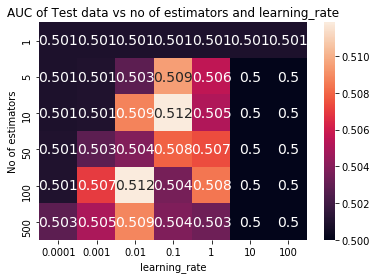

In [94]:
x_label='learning_rate'
ylabel='No of estimators'
title= 'AUC of Test data vs no of estimators and learning_rate'
plot_tables_metrics(test_auc1, learning_rate,estimators,x_label,ylabel, title)

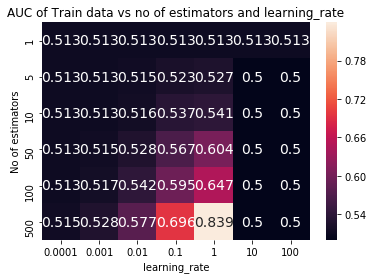

In [95]:
title= 'AUC of Train data vs no of estimators and learning_rate'
plot_tables_metrics(train_auc1, learning_rate,estimators,x_label,ylabel, title)

**Observation**

We can see that when no of tress are increasing and learning_rate is increasing, model is overfitting, hence training auc is increasing but test auc is decreasing. The no of tress and learning rate required is 10 and 0.1 respectively which is giving train and test auc 0.54 and 0.50 respectively, which is very close so our model is well fitting.

Note: As value of learning rate range b/w 0 to 1, model does not perform well either on train and val data with learning rate>1.

In [96]:

estimators=10
learning_rate=0.1
clf = XGBClassifier( learning_rate=learning_rate, n_estimators=estimators, n_jobs=-1, booster='gbtree')
clf.fit(train_data, train_traget)

# Prediction on Test data
pred = clf.predict_proba(test_data)


In [97]:
acc = accuracy_score(test_target, pred[:,0].round(), normalize=True) * float(100)
auc=roc_auc_score(test_target, pred[:,1])
print(" estimators: ",estimators," AUC: ",auc)

 estimators:  10  AUC:  0.511312


In [98]:
# ROC AUC Curve
y_true_train = train_traget
y_probas_train = clf.predict_proba(train_data)
y_true_test = test_target
y_probas_test = clf.predict_proba(test_data)

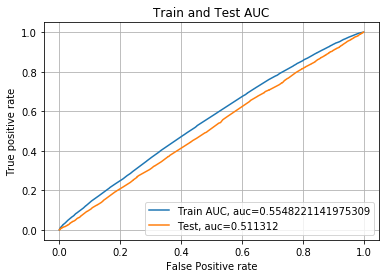

In [99]:
plot_train_test_ROC(y_true_train,clf,y_true_test,train_data,test_data)
plt.show()

**Observation**

We can see that the Train and Test ROC plot is bit overlapping on best no of trees =10 and learning rate=0.1. And the diff of train and Test AUC is minimal but overall auc is low so we can say that this model is underfitting . If we need better performance than this we may need to try different complex models and add some new features.

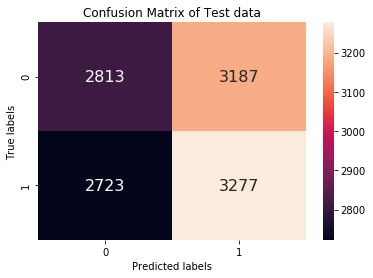

In [100]:

plotconfusionMatrix(y_true_test,clf,test_data)

**Observation**

We can see that on unseen data(Test set) our diagonal elements have almost similar number than off diagonal with very high no of FP and FN, ie. model is underfitting.If we need better performance than this, i.e to reduce further FP and FN and increase TP and TN then we may need to add some new features.

# [6] Conclusions

In [10]:

# Please compare all your models using Prettytable library
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model","Learning rate", "No of Trees", "Min data point to split", "AUC"]

x.add_row(["BOW", "Random Frest", "default",50,500, 0.91])
x.add_row(["BOW", "GBDT",  0.1, 500,"default", 0.92])
x.add_row(["BOW with feature engg", "GBDT",0.1, 500,"default", 0.84])
x.add_row(["TFIDF", "Random Frest", "default", 100,500, 0.90])
x.add_row(["TFIDF", "GBDT", 0.1, 500,"default", 0.91])
x.add_row(["TFIDF with feature engg", "GBDT",0.1, 500,"default", 0.88])
x.add_row(["AvgWord2Vec", "Random Frest", "default", 10,500, 0.05])
x.add_row(["AvgWord2Vec", "GBDT", 0.1, 10,"default", 0.05])
x.add_row(["TFIDFWord2Vec", "Random Frest", "default", 10,500, 0.5])
x.add_row(["TFIDFWord2Vec", "GBDT", 0.1,10,"default", 0.51])
print(x)

+-------------------------+--------------+---------------+-------------+-------------------------+------+
|        Vectorizer       |    Model     | Learning rate | No of Trees | Min data point to split | AUC  |
+-------------------------+--------------+---------------+-------------+-------------------------+------+
|           BOW           | Random Frest |    default    |      50     |           500           | 0.91 |
|           BOW           |     GBDT     |      0.1      |     500     |         default         | 0.92 |
|  BOW with feature engg  |     GBDT     |      0.1      |     500     |         default         | 0.84 |
|          TFIDF          | Random Frest |    default    |     100     |           500           | 0.9  |
|          TFIDF          |     GBDT     |      0.1      |     500     |         default         | 0.91 |
| TFIDF with feature engg |     GBDT     |      0.1      |     500     |         default         | 0.88 |
|       AvgWord2Vec       | Random Frest |    

**Observation**

We can see that with all 10 types of models Simple BOW vectorizer performing better with maximum AUC 92% on test data.TFIDF based vectorizer gave 2nd best solution with aprrox same AUC, after adding 4 new features performance of both BOW and TFIDF have reduced. On the other word2vec vectorizer on both avg and TFIDF performing worst and similar to random model.
